In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import os
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from scipy.stats import entropy as kl_divergence
import re






In [5]:
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:i+cell_height, j:j+cell_width]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum()
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))
    return entropy




Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos2
Processing folder: /Users/scliu

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/1686915042.py:76: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in df.groupby(['Incubation Time']):


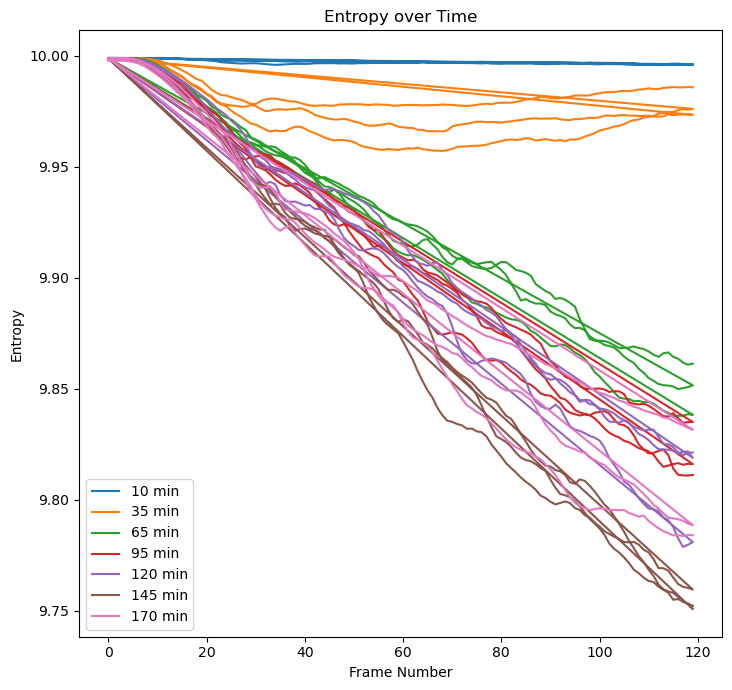

In [6]:
# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Function to calculate Shannon entropy of an image based on grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            # Adjust the cell to not go out of bounds
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum() + np.finfo(float).eps  # Normalize to sum to 1
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))  # Shannon entropy
    return entropy

def process_image_sequence(tiff_folder_path):
    # Get and sort tiff files
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        entropy = calculate_grid_entropy(image_np)
        entropy_over_time.append(entropy)
    
    return entropy_over_time

# Assuming base_path is the directory containing your 'posX' folders
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

video_data = []

for exp_folder in experiment_folders:
    # Extract incubation time from the experiment folder name
    incubation_time_str = exp_folder.split('_')[1]  # '10_min'
    incubation_time = int(incubation_time_str.split('_')[0])  # 10
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")  # Print the current folder being processed
        entropy_over_time = process_image_sequence(pos_folder)
        
        for i, entropy in enumerate(entropy_over_time):
            video_data.append({
                'Frame Number': i,
                'Entropy': entropy,
                'Incubation Time': incubation_time
            })

# Create DataFrame
df = pd.DataFrame(video_data)

# Display the DataFrame (optional)
print(df.head())

# Plotting the results (optional)
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Entropy'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

plt.tight_layout()
plt.show()


Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos2
Processing folder: /Users/scliu

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/2870083532.py:116: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in df.groupby(['Incubation Time']):
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/2870083532.py:125: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in df.groupby(['Incubation Time']):


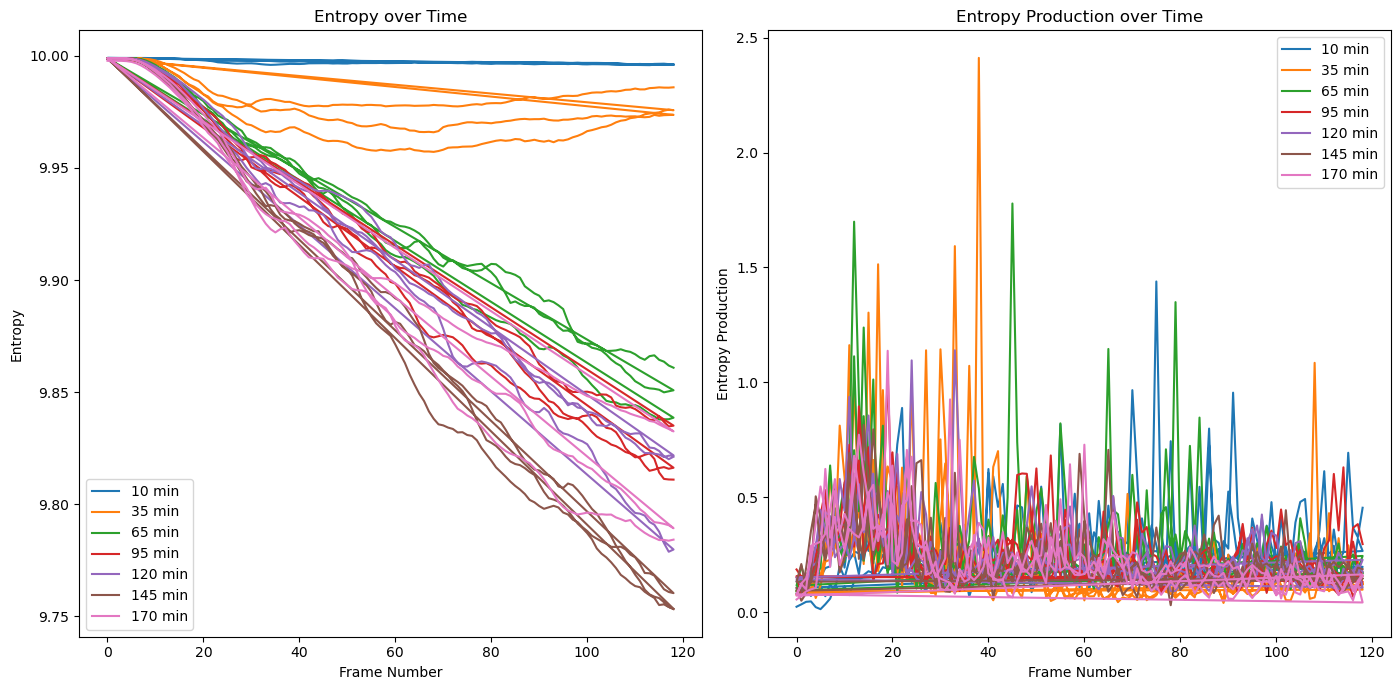

In [7]:
# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Calculate the probability distribution with a small epsilon
def calculate_probability_distribution(image_np, grid_size=(32, 32), num_bins=100, epsilon=1e-8):
    height, width = image_np.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    intensity_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image_np[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            intensity_values.append(mean_intensity)

    intensity_values = np.array(intensity_values)
    hist, bin_edges = np.histogram(intensity_values, bins=num_bins, density=True)
    probability_distribution = hist * np.diff(bin_edges)
    
    # Add epsilon to avoid zero probabilities
    probability_distribution += epsilon
    # Normalize to ensure it sums to 1
    probability_distribution /= np.sum(probability_distribution)
    
    return probability_distribution

# Calculate entropy for grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum()
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))
    return entropy

# Process each image sequence and return entropy and probability distributions
def process_image_sequence(tiff_folder_path):
    # Get and sort tiff files
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []
    probability_distributions = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        # Calculate entropy
        entropy = calculate_grid_entropy(image_np)
        entropy_over_time.append(entropy)
        
        # Calculate probability distribution
        prob_dist = calculate_probability_distribution(image_np)
        probability_distributions.append(prob_dist)
    
    return entropy_over_time, probability_distributions

# Calculate local entropy production from probability distributions
def calculate_local_entropy_production(prob_dists):
    entropy_production = []
    for t in range(1, len(prob_dists)):
        p_t = prob_dists[t-1]
        p_t1 = prob_dists[t]
        entropy_production.append(np.sum(p_t1 * np.log(p_t1 / (p_t + np.finfo(float).eps))))
    return np.array(entropy_production)

# Assuming base_path is the directory containing your 'posX' folders
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

video_data = []

for exp_folder in experiment_folders:
    # Extract incubation time from the experiment folder name
    incubation_time_str = exp_folder.split('_')[1]  # '10_min'
    incubation_time = int(incubation_time_str.split('_')[0])  # 10
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")  # Print the current folder being processed
        entropy_over_time, prob_dists = process_image_sequence(pos_folder)
        
        # Calculate entropy production
        entropy_production = calculate_local_entropy_production(prob_dists)

        for i, (entropy, entropy_prod) in enumerate(zip(entropy_over_time, entropy_production)):
            video_data.append({
                'Frame Number': i,
                'Entropy': entropy,
                'Entropy Production': entropy_prod,
                'Incubation Time': incubation_time
            })

# Create DataFrame
df = pd.DataFrame(video_data)

# Plotting the results
plt.figure(figsize=(21, 7))

# Plot Entropy
plt.subplot(1, 3, 1)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Entropy'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# Plot Entropy Production
plt.subplot(1, 3, 2)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Entropy Production'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Production')
plt.title('Entropy Production over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Function to calculate Shannon entropy of an image based on grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            # Ensure we do not exceed the image dimensions
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum() + np.finfo(float).eps  # Normalize to sum to 1
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))  # Shannon entropy
    return entropy

# Function to calculate KL divergence relative to a uniform distribution
def calculate_grid_kl_divergence(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    kl_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            cell_intensity = np.mean(cell)
            kl_values.append(cell_intensity)

    kl_values = np.array(kl_values)
    kl_values /= np.sum(kl_values) + np.finfo(float).eps  # Normalize to sum to 1

    uniform_distribution = np.ones_like(kl_values) / len(kl_values)
    kl_divergence_value = kl_divergence(kl_values, uniform_distribution)

    return kl_divergence_value

# Process a sequence of TIFF images to calculate entropy and KL divergence over time
def process_image_sequence(tiff_folder_path):
    tiff_files = [f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')]
    tiff_files.sort()  # Ensure files are processed in order
    entropy_over_time = []
    kl_divergence_over_time = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        size = 8
        image_np = uniform_filter(image_np, size=size)
        
        entropy = calculate_grid_entropy(image_np)
        kl_divergence_value = calculate_grid_kl_divergence(image_np)
        
        entropy_over_time.append(entropy)
        kl_divergence_over_time.append(kl_divergence_value)
    
    return entropy_over_time, kl_divergence_over_time

# Analyze entropy production based on entropy and KL divergence over time
def analyze_entropy_production(entropy_over_time, kl_divergence_over_time):
    delta_entropy_over_time = np.diff(entropy_over_time)
    mutual_information_estimation = kl_divergence_over_time[:-1]
    
    entropy_production_rate = delta_entropy_over_time - mutual_information_estimation
    
    if len(entropy_production_rate) == 0:
        return None
    
    avg_entropy_production_rate = np.mean(entropy_production_rate)
    total_entropy_production = np.sum(entropy_production_rate)
    
    bins = np.linspace(np.min(entropy_production_rate), np.max(entropy_production_rate), 100)
    hist, _ = np.histogram(entropy_production_rate, bins=bins, density=True)
    entropy_production_rate_distribution = hist
    
    rate_function = -np.log(entropy_production_rate_distribution + np.finfo(float).eps)
    
    time_intervals = [1, 5, 10, 20, 50, 100]
    avg_entropy_production_rates = []
    for interval in time_intervals:
        avg_rate = np.mean(entropy_production_rate[:interval])
        avg_entropy_production_rates.append(avg_rate)
    
    return entropy_production_rate, avg_entropy_production_rate, total_entropy_production, bins, entropy_production_rate_distribution, rate_function, time_intervals, avg_entropy_production_rates

# Base folder path for the data
base_folder = '/Volumes/SL_2023/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

all_data = []

# Process each experiment folder
for exp_folder in experiment_folders:
    incubation_time_str = exp_folder.split('_')[1]
    incubation_time = int(incubation_time_str.split('_')[0])
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")
        entropy_over_time, kl_divergence_over_time = process_image_sequence(pos_folder)

        entropy_production_data = analyze_entropy_production(entropy_over_time, kl_divergence_over_time)

        if entropy_production_data is not None:
            entropy_production_rate, avg_entropy_production_rate, total_entropy_production, bins, entropy_production_rate_distribution, rate_function, time_intervals, avg_entropy_production_rates = entropy_production_data
            
            data = {
                'Incubation Time': incubation_time,
                'Position': pos_folder,
                'Entropy over Time': entropy_over_time,
                'KL Divergence over Time': kl_divergence_over_time,
                'Entropy Production Rate': entropy_production_rate,
                'Average Entropy Production Rate': avg_entropy_production_rate,
                'Total Entropy Production': total_entropy_production,
                'Bins': bins,
                'Entropy Production Rate Distribution': entropy_production_rate_distribution,
                'Rate Function': rate_function,
                'Time Intervals': time_intervals,
                'Average Entropy Production Rates': avg_entropy_production_rates
            }
            
            all_data.append(data)
        else:
            print(f"Skipping folder {pos_folder} due to insufficient data for entropy production analysis.")

# Convert the data to a DataFrame
df = pd.DataFrame(all_data)

# Plot the results



Processing folder: /Volumes/SL_2023/0104/correlation_10_min_no_6.1_1/Pos0
Processing folder: /Volumes/SL_2023/0104/correlation_10_min_no_6.1_1/Pos1
Processing folder: /Volumes/SL_2023/0104/correlation_10_min_no_6.1_1/Pos2
Processing folder: /Volumes/SL_2023/0104/correlation_120_min_no_6.1_1/Pos0
Processing folder: /Volumes/SL_2023/0104/correlation_120_min_no_6.1_1/Pos1
Processing folder: /Volumes/SL_2023/0104/correlation_120_min_no_6.1_1/Pos2
Processing folder: /Volumes/SL_2023/0104/correlation_145_min_no_6.1_1/Pos0
Processing folder: /Volumes/SL_2023/0104/correlation_145_min_no_6.1_1/Pos1
Processing folder: /Volumes/SL_2023/0104/correlation_145_min_no_6.1_1/Pos2
Processing folder: /Volumes/SL_2023/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Volumes/SL_2023/0104/correlation_170_min_no_6.1_1/Pos1
Processing folder: /Volumes/SL_2023/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Volumes/SL_2023/0104/correlation_35_min_no_6.1_1/Pos0
Processing folder: /Volumes/S

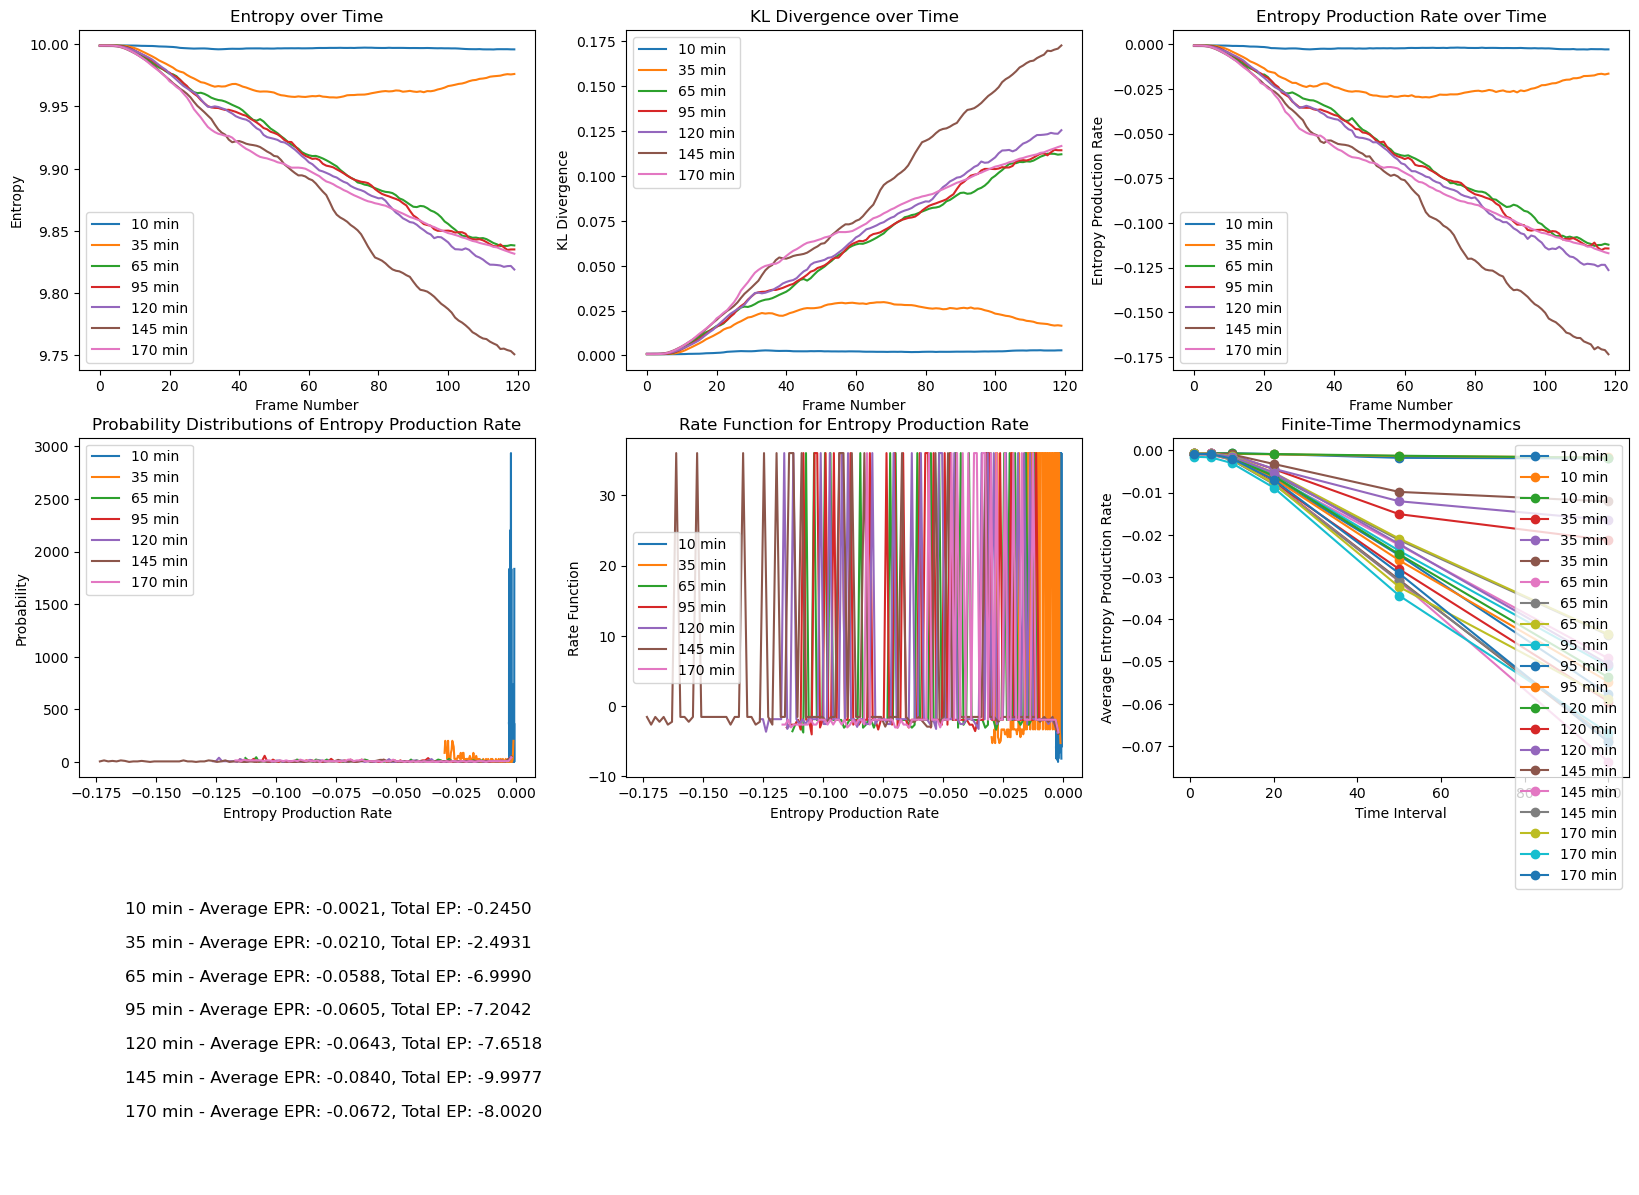

In [10]:
plt.figure(figsize=(20, 15))

# Entropy over Time
plt.subplot(3, 3, 1)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Entropy over Time'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# KL Divergence over Time
plt.subplot(3, 3, 2)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['KL Divergence over Time'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Time')
plt.legend()

# Entropy Production Rate over Time
plt.subplot(3, 3, 3)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Entropy Production Rate'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Production Rate')
plt.title('Entropy Production Rate over Time')
plt.legend()

# Probability Distributions of Entropy Production Rate
plt.subplot(3, 3, 4)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Bins'].iloc[0][:-1], group['Entropy Production Rate Distribution'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Entropy Production Rate')
plt.ylabel('Probability')
plt.title('Probability Distributions of Entropy Production Rate')
plt.legend()

# Rate Function for Entropy Production Rate
plt.subplot(3, 3, 5)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Bins'].iloc[0][:-1], group['Rate Function'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Entropy Production Rate')
plt.ylabel('Rate Function')
plt.title('Rate Function for Entropy Production Rate')
plt.legend()

# Finite-Time Thermodynamics
plt.subplot(3, 3, 6)
for incubation_time, group in df.groupby('Incubation Time'):
    for time_intervals, avg_entropy_production_rates in zip(group['Time Intervals'], group['Average Entropy Production Rates']):
        plt.plot(time_intervals, avg_entropy_production_rates, 'o-', label=f'{incubation_time} min')
plt.xlabel('Time Interval')
plt.ylabel('Average Entropy Production Rate')
plt.title('Finite-Time Thermodynamics')
plt.legend()

# Summary of Average and Total Entropy Production
plt.subplot(3, 3, 7)
plt.axis('off')
y_position = 0.8  # Start position for text
for incubation_time, group in df.groupby('Incubation Time'):
    avg_epr = group['Average Entropy Production Rate'].iloc[0]
    total_ep = group['Total Entropy Production'].iloc[0]
    plt.text(0.1, y_position, f'{incubation_time} min - Average EPR: {avg_epr:.4f}, Total EP: {total_ep:.4f}', fontsize=12)
    y_position -= 0.1  # Move to the next line for the next summary



In [11]:
# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# Function to calculate Shannon entropy of an image based on grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i + cell_height, height), j:min(j + cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum() + np.finfo(float).eps  # Normalize to sum to 1
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))  # Shannon entropy
    return entropy

# Function to calculate KL divergence with respect to a uniform distribution
def calculate_grid_kl_divergence(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    kl_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i + cell_height, height), j:min(j + cell_width, width)]
            cell_intensity = np.mean(cell)
            kl_values.append(cell_intensity)

    kl_values = np.array(kl_values)
    kl_values /= np.sum(kl_values)

    uniform_distribution = np.ones_like(kl_values) / len(kl_values)
    kl_divergence_value = kl_divergence(kl_values, uniform_distribution)

    return kl_divergence_value

# Process each image sequence and return entropy and KL divergence over time
def process_image_sequence(tiff_folder_path):
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []
    kl_divergence_over_time = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        entropy = calculate_grid_entropy(image_np)
        kl_divergence_value = calculate_grid_kl_divergence(image_np)
        
        entropy_over_time.append(entropy)
        kl_divergence_over_time.append(kl_divergence_value)
    
    return entropy_over_time, kl_divergence_over_time

# Analyze the entropy production based on entropy and KL divergence over time
def analyze_entropy_production(entropy_over_time, kl_divergence_over_time):
    delta_entropy_over_time = np.diff(entropy_over_time)
    mutual_information_estimation = kl_divergence_over_time[:-1]
    
    entropy_production_rate = delta_entropy_over_time - mutual_information_estimation
    
    if len(entropy_production_rate) == 0:
        return None
    
    avg_entropy_production_rate = np.mean(entropy_production_rate)
    total_entropy_production = np.sum(entropy_production_rate)
    
    bins = np.linspace(np.min(entropy_production_rate), np.max(entropy_production_rate), 100)
    hist, _ = np.histogram(entropy_production_rate, bins=bins, density=True)
    entropy_production_rate_distribution = hist
    
    neg_entropy_production_rate = -entropy_production_rate
    neg_hist, _ = np.histogram(neg_entropy_production_rate, bins=bins, density=True)
    neg_entropy_production_rate_distribution = neg_hist
    
    ratio = entropy_production_rate_distribution / (neg_entropy_production_rate_distribution + np.finfo(float).eps)
    expected_ratio = np.exp(bins[:-1])
    
    rate_function = -np.log(entropy_production_rate_distribution + np.finfo(float).eps)
    
    time_intervals = [1, 5, 10, 20, 50, 100]
    avg_entropy_production_rates = []
    for interval in time_intervals:
        avg_rate = np.mean(entropy_production_rate[:interval])
        avg_entropy_production_rates.append(avg_rate)
    
    return entropy_production_rate, avg_entropy_production_rate, total_entropy_production, bins, entropy_production_rate_distribution, neg_entropy_production_rate_distribution, ratio, expected_ratio, rate_function, time_intervals, avg_entropy_production_rates

# Define base folder and experiment folders
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

all_data = []

for exp_folder in experiment_folders:
    incubation_time_str = exp_folder.split('_')[1]
    incubation_time = int(incubation_time_str.split('_')[0])
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")
        entropy_over_time, kl_divergence_over_time = process_image_sequence(pos_folder)

        entropy_production_data = analyze_entropy_production(entropy_over_time, kl_divergence_over_time)

        if entropy_production_data is not None:
            entropy_production_rate, avg_entropy_production_rate, total_entropy_production, bins, entropy_production_rate_distribution, neg_entropy_production_rate_distribution, ratio, expected_ratio, rate_function, time_intervals, avg_entropy_production_rates = entropy_production_data
            
            data = {
                'Incubation Time': incubation_time,
                'Position': pos_folder,
                'Entropy over Time': entropy_over_time,
                'KL Divergence over Time': kl_divergence_over_time,
                'Entropy Production Rate': entropy_production_rate,
                'Average Entropy Production Rate': avg_entropy_production_rate,
                'Total Entropy Production': total_entropy_production,
                'Bins': bins,
                'Entropy Production Rate Distribution': entropy_production_rate_distribution,
                'Negative Entropy Production Rate Distribution': neg_entropy_production_rate_distribution,
                'Ratio': ratio,
                'Expected Ratio': expected_ratio,
                'Rate Function': rate_function,
                'Time Intervals': time_intervals,
                'Average Entropy Production Rates': avg_entropy_production_rates
            }
            
            all_data.append(data)
        else:
            print(f"Skipping folder {pos_folder} due to insufficient data for entropy production analysis.")

# Convert the data to a DataFrame
df = pd.DataFrame(all_data)



Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1


/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_95_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/

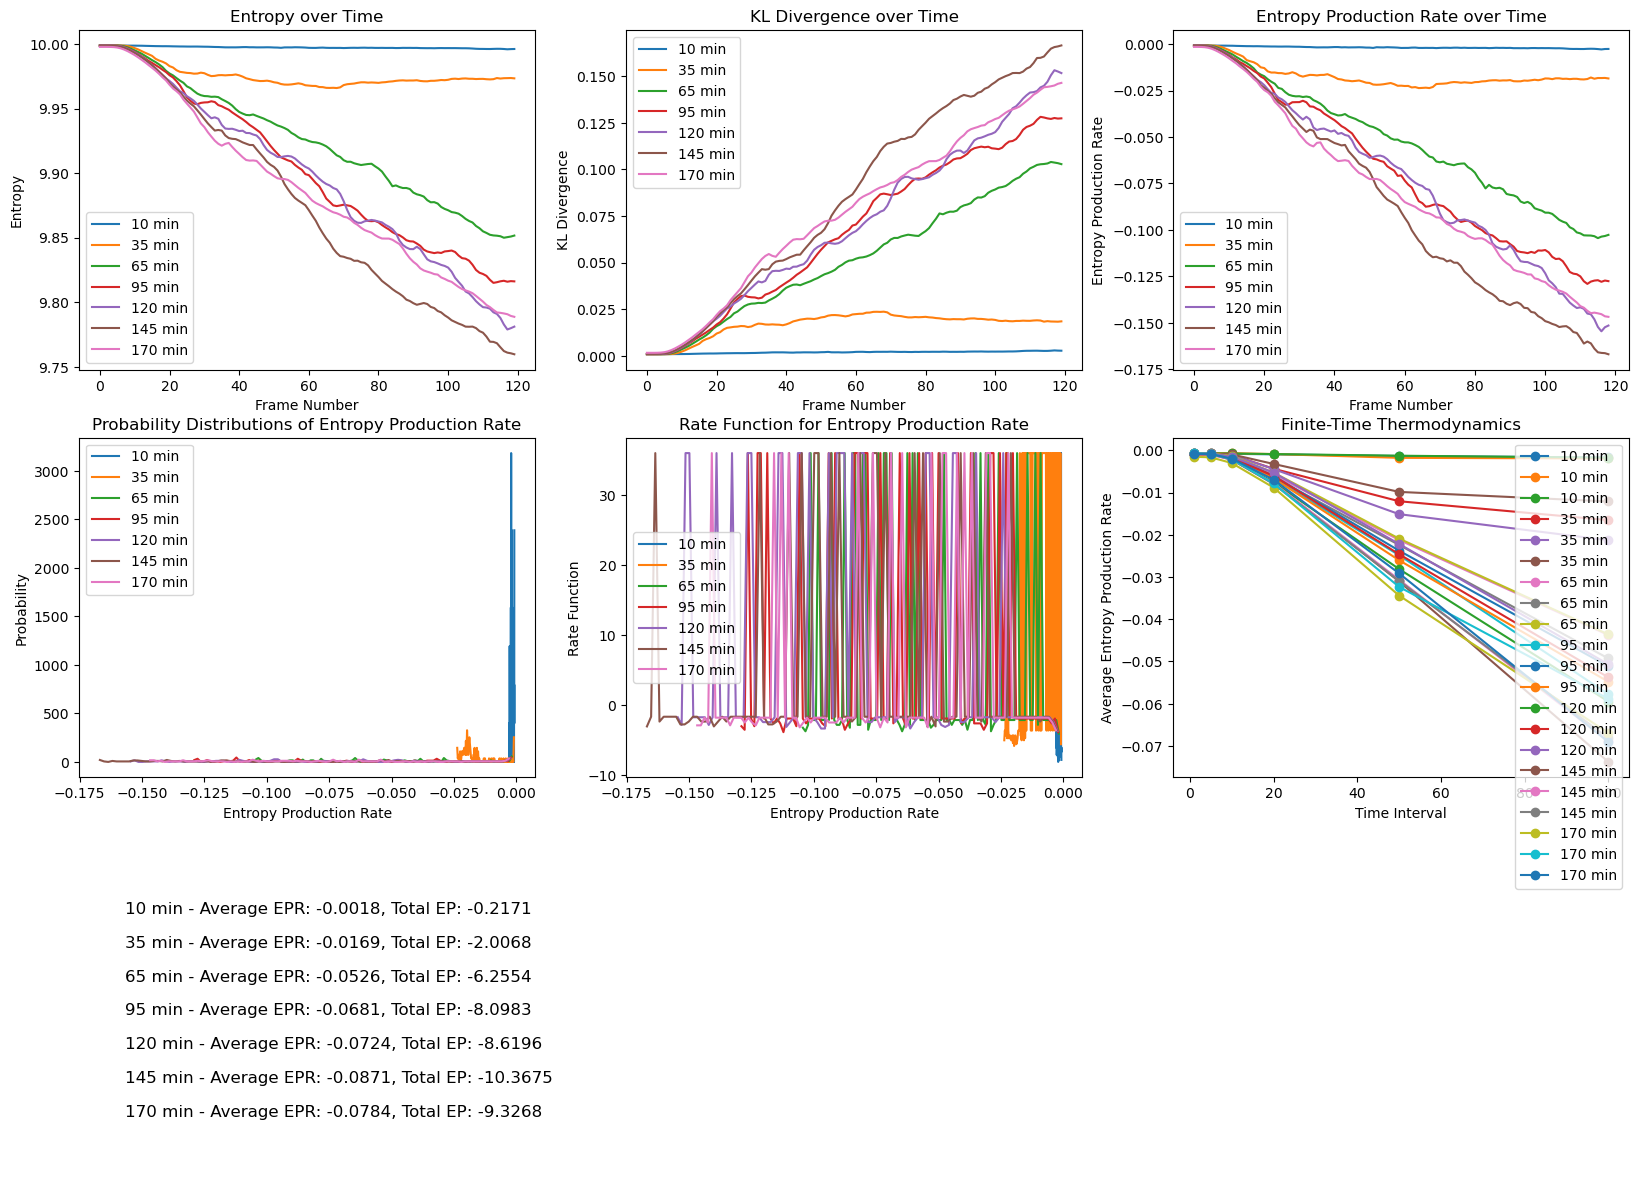

In [12]:
plt.figure(figsize=(20, 15))

# Entropy over Time
plt.subplot(3, 3, 1)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Entropy over Time'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# KL Divergence over Time
plt.subplot(3, 3, 2)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['KL Divergence over Time'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Time')
plt.legend()

# Entropy Production Rate over Time
plt.subplot(3, 3, 3)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Entropy Production Rate'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Production Rate')
plt.title('Entropy Production Rate over Time')
plt.legend()

# Probability Distributions of Entropy Production Rate
plt.subplot(3, 3, 4)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Bins'].iloc[0][:-1], group['Entropy Production Rate Distribution'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Entropy Production Rate')
plt.ylabel('Probability')
plt.title('Probability Distributions of Entropy Production Rate')
plt.legend()

# Rate Function for Entropy Production Rate
plt.subplot(3, 3, 5)
for incubation_time, group in df.groupby('Incubation Time'):
    plt.plot(group['Bins'].iloc[0][:-1], group['Rate Function'].iloc[0], label=f'{incubation_time} min')
plt.xlabel('Entropy Production Rate')
plt.ylabel('Rate Function')
plt.title('Rate Function for Entropy Production Rate')
plt.legend()

# Finite-Time Thermodynamics
plt.subplot(3, 3, 6)
for incubation_time, group in df.groupby('Incubation Time'):
    for time_intervals, avg_entropy_production_rates in zip(group['Time Intervals'], group['Average Entropy Production Rates']):
        plt.plot(time_intervals, avg_entropy_production_rates, 'o-', label=f'{incubation_time} min')
plt.xlabel('Time Interval')
plt.ylabel('Average Entropy Production Rate')
plt.title('Finite-Time Thermodynamics')
plt.legend()

# Summary of Average and Total Entropy Production
plt.subplot(3, 3, 7)
plt.axis('off')
y_position = 0.8  # Start position for text
for incubation_time, group in df.groupby('Incubation Time'):
    avg_epr = group['Average Entropy Production Rate'].iloc[0]
    total_ep = group['Total Entropy Production'].iloc[0]
    plt.text(0.1, y_position, f'{incubation_time} min - Average EPR: {avg_epr:.4f}, Total EP: {total_ep:.4f}', fontsize=12)
    y_position -= 0.1  # Move to the next line for the next summary



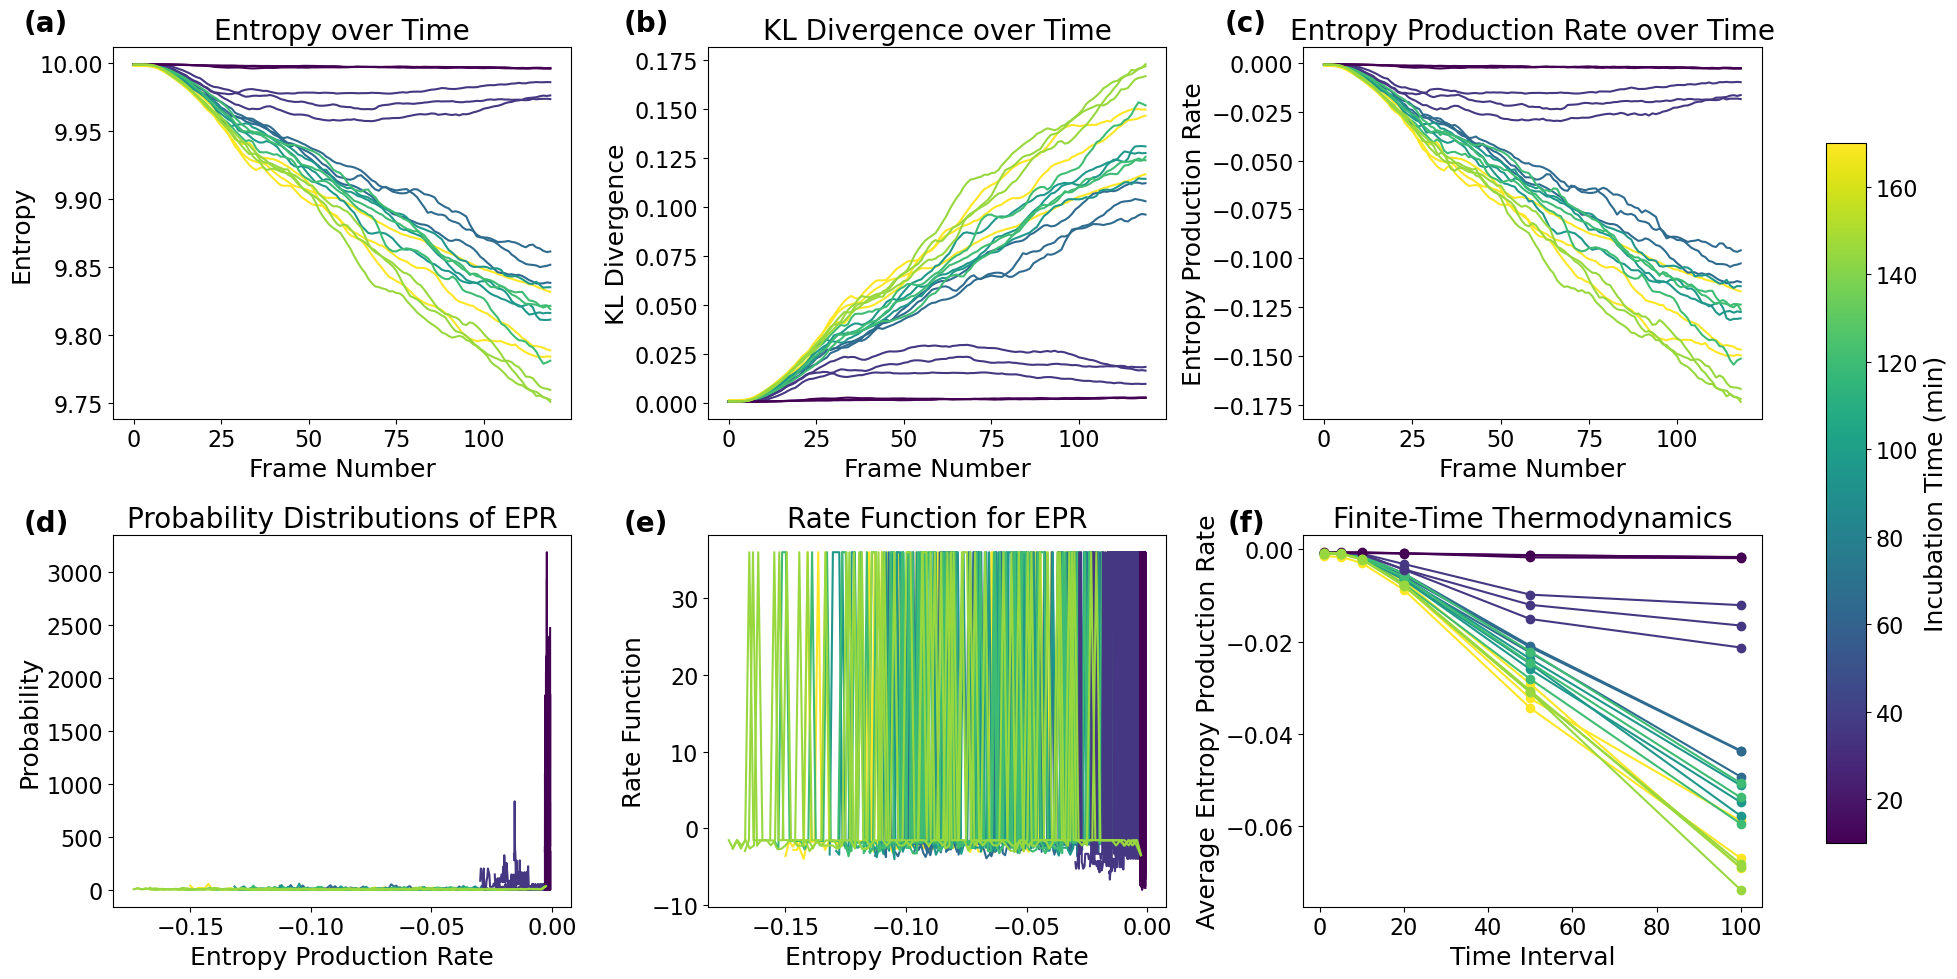

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Set font sizes globally
plt.rcParams.update({'font.size': 16})  # Adjust the size as needed

# Assuming 'df' is the DataFrame containing the data

# Extract unique incubation times
incubation_times = df['Incubation Time'].unique()
norm = Normalize(vmin=min(incubation_times), vmax=max(incubation_times))
cmap = plt.get_cmap('viridis')

# Plot the results with incubation time as a color bar
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot 1: Entropy over Time
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[0, 0].plot(row['Entropy over Time'], color=color)
axes[0, 0].set_xlabel('Frame Number', fontsize=18)
axes[0, 0].set_ylabel('Entropy', fontsize=18)
axes[0, 0].set_title('Entropy over Time', fontsize=20)

# Plot 2: KL Divergence over Time
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[0, 1].plot(row['KL Divergence over Time'], color=color)
axes[0, 1].set_xlabel('Frame Number', fontsize=18)
axes[0, 1].set_ylabel('KL Divergence', fontsize=18)
axes[0, 1].set_title('KL Divergence over Time', fontsize=20)

# Plot 3: Entropy Production Rate over Time
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[0, 2].plot(row['Entropy Production Rate'], color=color)
axes[0, 2].set_xlabel('Frame Number', fontsize=18)
axes[0, 2].set_ylabel('Entropy Production Rate', fontsize=18)
axes[0, 2].set_title('Entropy Production Rate over Time', fontsize=20)

# Plot 4: Probability Distributions of Entropy Production Rate
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[1, 0].plot(row['Bins'][:-1], row['Entropy Production Rate Distribution'], color=color)
axes[1, 0].set_xlabel('Entropy Production Rate', fontsize=18)
axes[1, 0].set_ylabel('Probability', fontsize=18)
axes[1, 0].set_title('Probability Distributions of EPR', fontsize=20)

# Plot 5: Rate Function for Entropy Production Rate
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[1, 1].plot(row['Bins'][:-1], row['Rate Function'], color=color)
axes[1, 1].set_xlabel('Entropy Production Rate', fontsize=18)
axes[1, 1].set_ylabel('Rate Function', fontsize=18)
axes[1, 1].set_title('Rate Function for EPR', fontsize=20)

# Plot 6: Finite-Time Thermodynamics
for _, row in df.iterrows():
    color = cmap(norm(row['Incubation Time']))
    axes[1, 2].plot(row['Time Intervals'], row['Average Entropy Production Rates'], 'o-', color=color)
axes[1, 2].set_xlabel('Time Interval', fontsize=18)
axes[1, 2].set_ylabel('Average Entropy Production Rate', fontsize=18)
axes[1, 2].set_title('Finite-Time Thermodynamics', fontsize=20)

# Adjust layout to make space for the color bar
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add color bar to indicate incubation time outside the plot area on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cbar_ax, orientation='vertical', label='Incubation Time (min)')
cbar.ax.tick_params(labelsize=16)  # Set font size for color bar ticks
cbar.ax.set_ylabel('Incubation Time (min)', fontsize=18)

# Add overall annotations outside the plot area for subplot labels
fig.text(0.03, 0.97, '(a)', fontsize=20, weight='bold', ha='center', va='center')
fig.text(0.33, 0.97, '(b)', fontsize=20, weight='bold', ha='center', va='center')
fig.text(0.63, 0.97, '(c)', fontsize=20, weight='bold', ha='center', va='center')
fig.text(0.03, 0.47, '(d)', fontsize=20, weight='bold', ha='center', va='center')
fig.text(0.33, 0.47, '(e)', fontsize=20, weight='bold', ha='center', va='center')
fig.text(0.63, 0.47, '(f)', fontsize=20, weight='bold', ha='center', va='center')

# Show plot
plt.show()


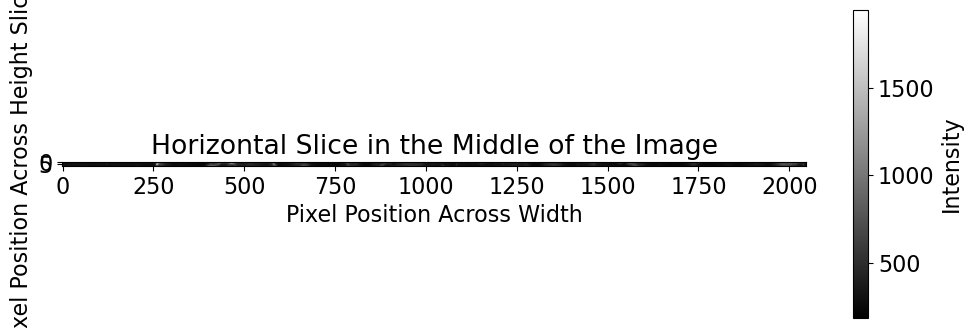

In [35]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_specific_frame(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)

    # Extract a horizontal slice in the middle of the image with a height of 10 pixels
    mid_height = image_np.shape[0] // 2
    slice_height = 10
    horizontal_slice = image_np[mid_height:mid_height + slice_height, :]

    # Plot the intensity values of the slice with equal aspect ratio
    plt.figure(figsize=(12, 4))
    plt.imshow(horizontal_slice, aspect='equal', cmap='gray')  # Set aspect to 'equal'
    plt.colorbar(label='Intensity')
    plt.title('Horizontal Slice in the Middle of the Image')
    plt.xlabel('Pixel Position Across Width')
    plt.ylabel('Pixel Position Across Height Slice')
    plt.show()


# Assuming the base path is correctly set
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = sorted([f for f in os.listdir(base_folder) if 'correlation' in f], key=natural_sort_key)

# Select the first folder and get its path
if experiment_folders:
    first_exp_folder = experiment_folders[0]
    exp_folder_path = os.path.join(base_folder, first_exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]
    if pos_folders:
        first_pos_folder = pos_folders[0]
        tiff_files = sorted([f for f in os.listdir(first_pos_folder) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
        if len(tiff_files) > 19:  # Ensure there is at least 20 files
            tiff_file_path = os.path.join(first_pos_folder, tiff_files[19])  # 20th file
            process_specific_frame(tiff_file_path)
        else:
            print("Not enough TIFF files in the folder to process the 20th frame.")
    else:
        print("No position folders found.")
else:
    print("No experiment folders found.")


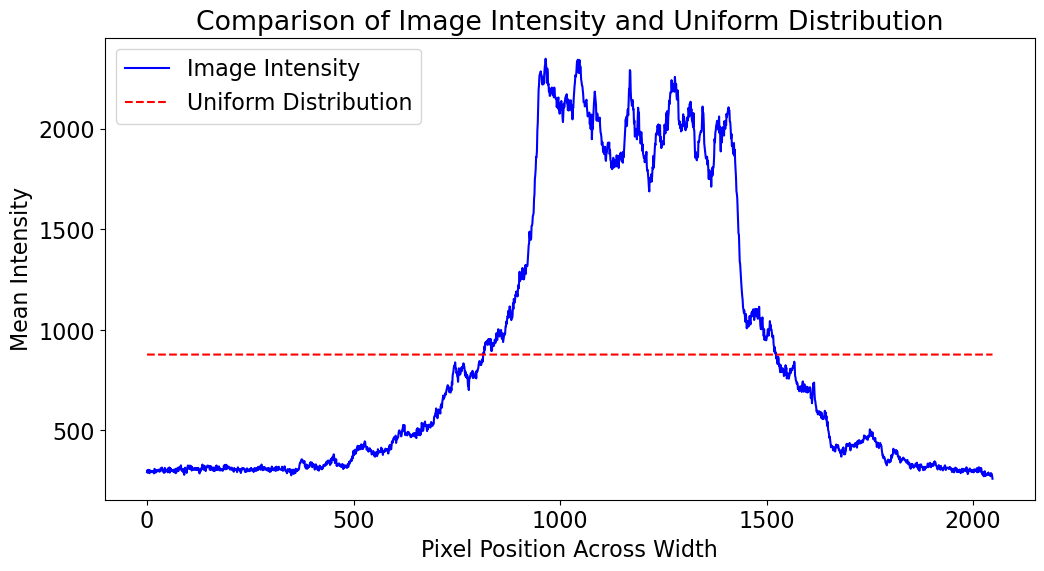

In [41]:
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_specific_frame(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)

    # Extract a horizontal slice in the middle of the image with a height of 10 pixels
    mid_height = image_np.shape[0] // 2
    slice_height = 10
    horizontal_slice = image_np[mid_height:mid_height + slice_height, :]

    # Compute the mean intensity values along the height of the slice
    mean_intensity_values = horizontal_slice.mean(axis=0)

    # Generate a uniform distribution of the same length
    uniform_distribution = np.full_like(mean_intensity_values, np.mean(mean_intensity_values))

    # Plot the intensity values and the uniform distribution
    plt.figure(figsize=(12, 6))
    plt.plot(mean_intensity_values, label='Image Intensity', color='blue')
    plt.plot(uniform_distribution, label='Uniform Distribution', color='red', linestyle='--')
    plt.xlabel('Pixel Position Across Width')
    plt.ylabel('Mean Intensity')
    plt.title('Comparison of Image Intensity and Uniform Distribution')
    plt.legend()
    plt.show()

# Assuming the base path is correctly set
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = sorted([f for f in os.listdir(base_folder) if 'correlation' in f], key=natural_sort_key)

# Select the first folder and get its path
if experiment_folders:
    first_exp_folder = experiment_folders[5]
    exp_folder_path = os.path.join(base_folder, first_exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]
    if pos_folders:
        first_pos_folder = pos_folders[0]
        tiff_files = sorted([f for f in os.listdir(first_pos_folder) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
        if len(tiff_files) > 19:  # Ensure there is at least 20 files
            tiff_file_path = os.path.join(first_pos_folder, tiff_files[19])  # 20th file
            process_specific_frame(tiff_file_path)
        else:
            print("Not enough TIFF files in the folder to process the 20th frame.")
    else:
        print("No position folders found.")
else:
    print("No experiment folders found.")


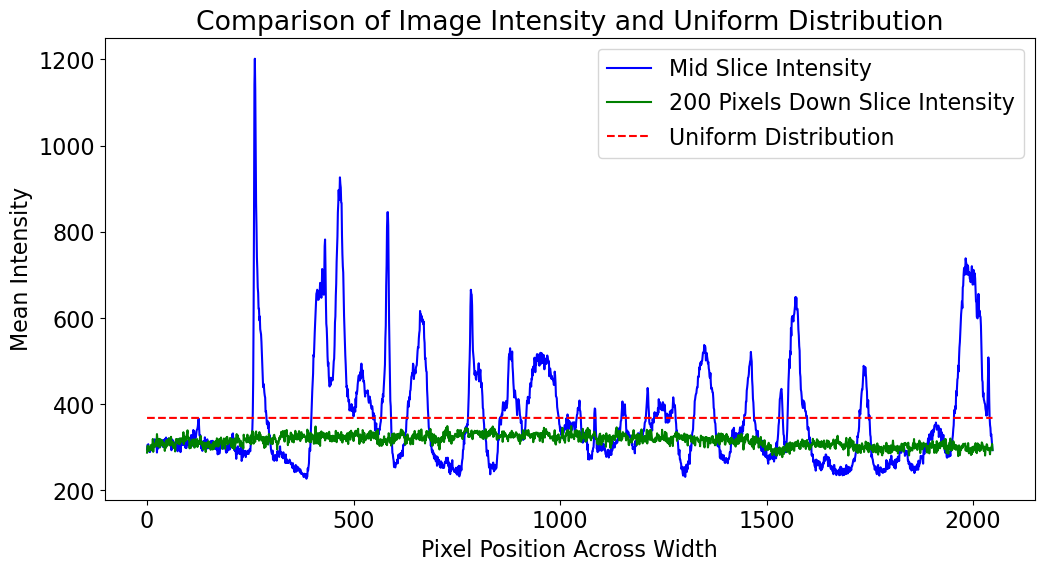

In [42]:
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_specific_frame(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)

    # Extract a horizontal slice in the middle of the image with a height of 10 pixels
    mid_height = image_np.shape[0] // 2
    slice_height = 10
    horizontal_slice = image_np[mid_height:mid_height + slice_height, :]
    mean_intensity_values_mid = horizontal_slice.mean(axis=0)

    # Extract another horizontal slice 200 pixels down from the middle
    offset = 200
    if mid_height + offset + slice_height < image_np.shape[0]:
        horizontal_slice_down = image_np[mid_height + offset:mid_height + offset + slice_height, :]
        mean_intensity_values_down = horizontal_slice_down.mean(axis=0)
    else:
        raise ValueError("The image is not tall enough to extract a slice 200 pixels down from the middle.")

    # Generate a uniform distribution of the same length
    uniform_distribution = np.full_like(mean_intensity_values_mid, np.mean(mean_intensity_values_mid))

    # Plot the intensity values and the uniform distribution
    plt.figure(figsize=(12, 6))
    plt.plot(mean_intensity_values_mid, label='Mid Slice Intensity', color='blue')
    plt.plot(mean_intensity_values_down, label='200 Pixels Down Slice Intensity', color='green')
    plt.plot(uniform_distribution, label='Uniform Distribution', color='red', linestyle='--')
    plt.xlabel('Pixel Position Across Width')
    plt.ylabel('Mean Intensity')
    plt.title('Comparison of Image Intensity and Uniform Distribution')
    plt.legend()
    plt.show()

# Assuming the base path is correctly set
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = sorted([f for f in os.listdir(base_folder) if 'correlation' in f], key=natural_sort_key)

# Select the first folder and get its path
if experiment_folders:
    first_exp_folder = experiment_folders[0]
    exp_folder_path = os.path.join(base_folder, first_exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]
    if pos_folders:
        first_pos_folder = pos_folders[0]
        tiff_files = sorted([f for f in os.listdir(first_pos_folder) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
        if len(tiff_files) > 19:  # Ensure there is at least 20 files
            tiff_file_path = os.path.join(first_pos_folder, tiff_files[19])  # 20th file
            process_specific_frame(tiff_file_path)
        else:
            print("Not enough TIFF files in the folder to process the 20th frame.")
    else:
        print("No position folders found.")
else:
    print("No experiment folders found.")


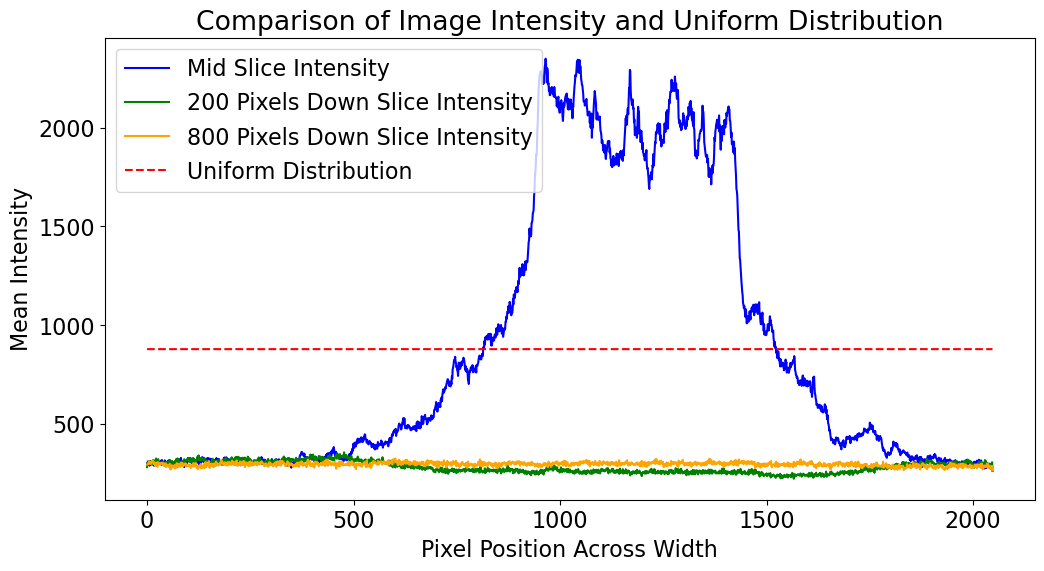

In [46]:
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_specific_frame(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)

    # Extract a horizontal slice in the middle of the image with a height of 10 pixels
    mid_height = image_np.shape[0] // 2
    slice_height = 10
    horizontal_slice = image_np[mid_height:mid_height + slice_height, :]
    mean_intensity_values_mid = horizontal_slice.mean(axis=0)

    # Extract another horizontal slice 200 pixels down from the middle
    offset_200 = 200
    if mid_height + offset_200 + slice_height < image_np.shape[0]:
        horizontal_slice_200_down = image_np[mid_height + offset_200:mid_height + offset_200 + slice_height, :]
        mean_intensity_values_200_down = horizontal_slice_200_down.mean(axis=0)
    else:
        raise ValueError("The image is not tall enough to extract a slice 200 pixels down from the middle.")

    # Extract another horizontal slice 800 pixels down from the middle
    offset_800 = 1000
    if mid_height + offset_800 + slice_height < image_np.shape[0]:
        horizontal_slice_800_down = image_np[mid_height + offset_800:mid_height + offset_800 + slice_height, :]
        mean_intensity_values_800_down = horizontal_slice_800_down.mean(axis=0)
    else:
        raise ValueError("The image is not tall enough to extract a slice 800 pixels down from the middle.")

    # Generate a uniform distribution of the same length
    uniform_distribution = np.full_like(mean_intensity_values_mid, np.mean(mean_intensity_values_mid))

    # Plot the intensity values and the uniform distribution
    plt.figure(figsize=(12, 6))
    plt.plot(mean_intensity_values_mid, label='Mid Slice Intensity', color='blue')
    plt.plot(mean_intensity_values_200_down, label='200 Pixels Down Slice Intensity', color='green')
    plt.plot(mean_intensity_values_800_down, label='800 Pixels Down Slice Intensity', color='orange')
    plt.plot(uniform_distribution, label='Uniform Distribution', color='red', linestyle='--')
    plt.xlabel('Pixel Position Across Width')
    plt.ylabel('Mean Intensity')
    plt.title('Comparison of Image Intensity and Uniform Distribution')
    plt.legend()
    plt.show()

# Assuming the base path is correctly set
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = sorted([f for f in os.listdir(base_folder) if 'correlation' in f], key=natural_sort_key)

# Select the first folder and get its path
if experiment_folders:
    first_exp_folder = experiment_folders[5]
    exp_folder_path = os.path.join(base_folder, first_exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]
    if pos_folders:
        first_pos_folder = pos_folders[0]
        tiff_files = sorted([f for f in os.listdir(first_pos_folder) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
        if len(tiff_files) > 19:  # Ensure there is at least 20 files
            tiff_file_path = os.path.join(first_pos_folder, tiff_files[19])  # 20th file
            process_specific_frame(tiff_file_path)
        else:
            print("Not enough TIFF files in the folder to process the 20th frame.")
    else:
        print("No position folders found.")
else:
    print("No experiment folders found.")


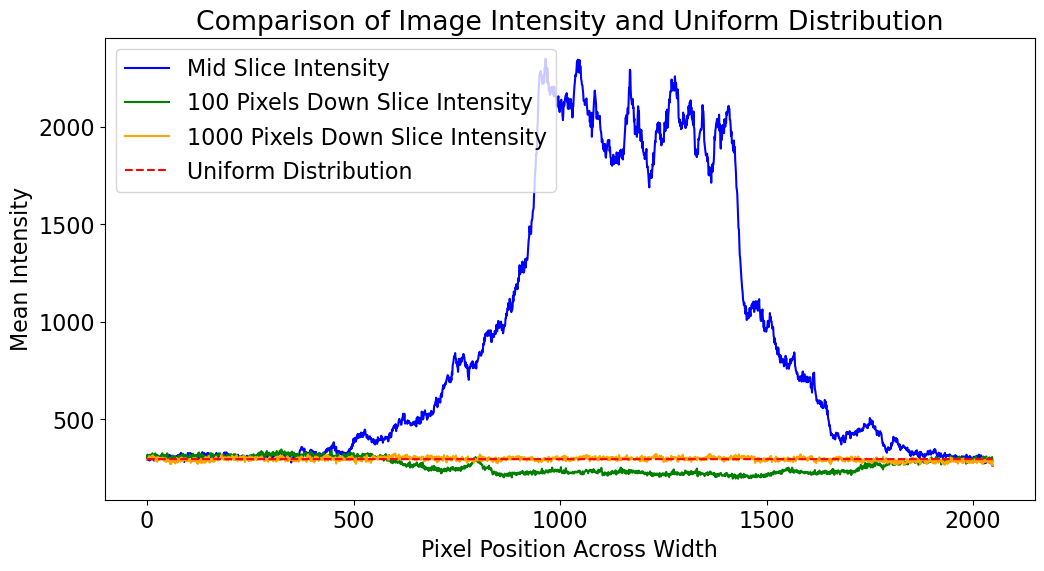

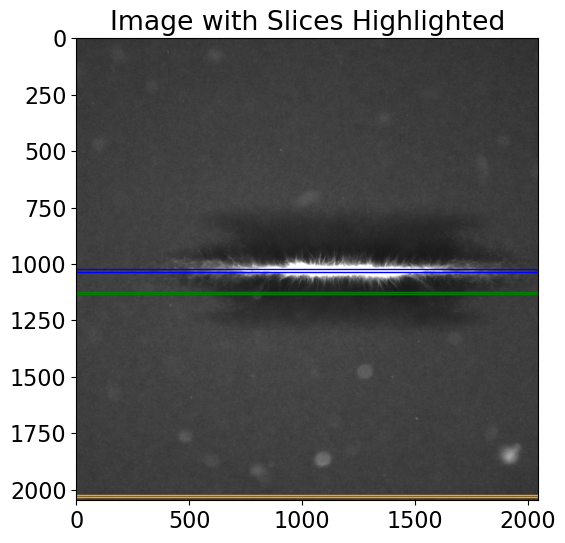

In [64]:
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_specific_frame(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)

    # Extract a horizontal slice in the middle of the image with a height of 10 pixels
    mid_height = image_np.shape[0] // 2
    slice_height = 10
    horizontal_slice = image_np[mid_height:mid_height + slice_height, :]
    mean_intensity_values_mid = horizontal_slice.mean(axis=0)

    # Extract another horizontal slice 200 pixels down from the middle
    offset_200 = 100
    if mid_height + offset_200 + slice_height < image_np.shape[0]:
        horizontal_slice_200_down = image_np[mid_height + offset_200:mid_height + offset_200 + slice_height, :]
        mean_intensity_values_200_down = horizontal_slice_200_down.mean(axis=0)
    else:
        raise ValueError("The image is not tall enough to extract a slice 200 pixels down from the middle.")

    # Extract another horizontal slice 800 pixels down from the middle
    offset_800 = 1000
    if mid_height + offset_800 + slice_height < image_np.shape[0]:
        horizontal_slice_800_down = image_np[mid_height + offset_800:mid_height + offset_800 + slice_height, :]
        mean_intensity_values_800_down = horizontal_slice_800_down.mean(axis=0)
    else:
        raise ValueError("The image is not tall enough to extract a slice 800 pixels down from the middle.")

    # Generate a uniform distribution of the same length based on the mean of the 800 pixels down slice
    uniform_distribution = np.full_like(mean_intensity_values_mid, np.mean(mean_intensity_values_800_down))

    # Plot the intensity values and the uniform distribution
    plt.figure(figsize=(12, 6))
    plt.plot(mean_intensity_values_mid, label='Mid Slice Intensity', color='blue')
    plt.plot(mean_intensity_values_200_down, label='100 Pixels Down Slice Intensity', color='green')
    plt.plot(mean_intensity_values_800_down, label='1000 Pixels Down Slice Intensity', color='orange')
    plt.plot(uniform_distribution, label='Uniform Distribution', color='red', linestyle='--')
    plt.xlabel('Pixel Position Across Width')
    plt.ylabel('Mean Intensity')
    plt.title('Comparison of Image Intensity and Uniform Distribution')
    plt.legend()
    plt.show()

    # Increase the intensity of the image for display
    scaling_factor = 0.3  # You can adjust this factor to increase or decrease brightness
    image_np_display = np.clip(image_np * scaling_factor, 0, 255).astype(np.uint8)

    # Plot the whole image and box up the slices
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(image_np_display, cmap='gray')

    # Add rectangles for the slices
    rect_mid = patches.Rectangle((0, mid_height), image_np.shape[1], slice_height, linewidth=1, edgecolor='blue', facecolor='none')
    rect_200 = patches.Rectangle((0, mid_height + offset_200), image_np.shape[1], slice_height, linewidth=1, edgecolor='green', facecolor='none')
    rect_800 = patches.Rectangle((0, mid_height + offset_800), image_np.shape[1], slice_height, linewidth=1, edgecolor='orange', facecolor='none')

    ax.add_patch(rect_mid)
    ax.add_patch(rect_200)
    ax.add_patch(rect_800)

    plt.title('Image with Slices Highlighted')
    plt.show()

# Assuming the base path is correctly set
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = sorted([f for f in os.listdir(base_folder) if 'correlation' in f], key=natural_sort_key)

# Select the first folder and get its path
if experiment_folders:
    first_exp_folder = experiment_folders[5]
    exp_folder_path = os.path.join(base_folder, first_exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]
    if pos_folders:
        first_pos_folder = pos_folders[0]
        tiff_files = sorted([f for f in os.listdir(first_pos_folder) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
        if len(tiff_files) > 19:  # Ensure there is at least 20 files
            tiff_file_path = os.path.join(first_pos_folder, tiff_files[19])  # 20th file
            process_specific_frame(tiff_file_path)
        else:
            print("Not enough TIFF files in the folder to process the 20th frame.")
    else:
        print("No position folders found.")
else:
    print("No experiment folders found.")


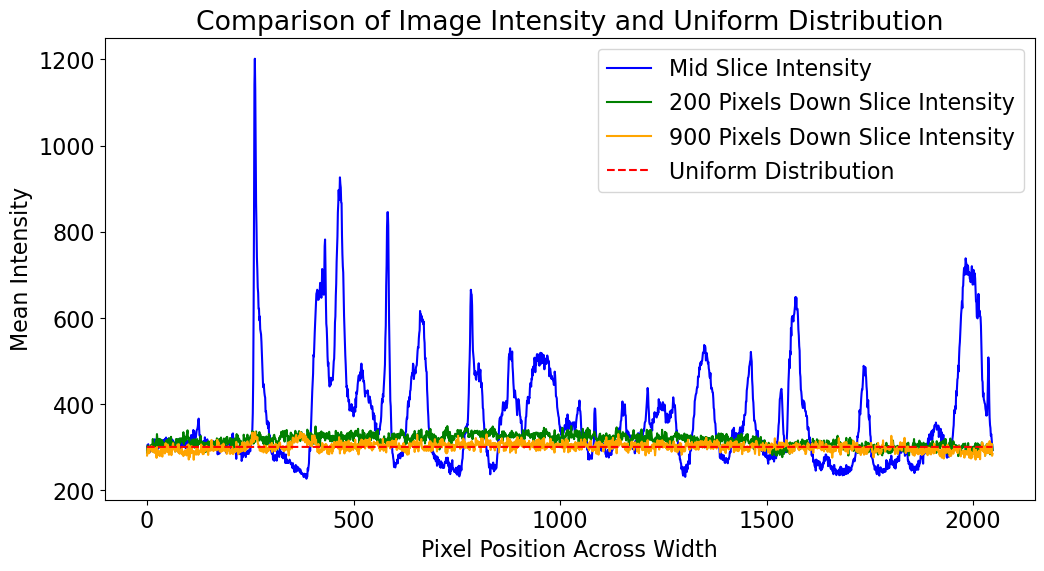

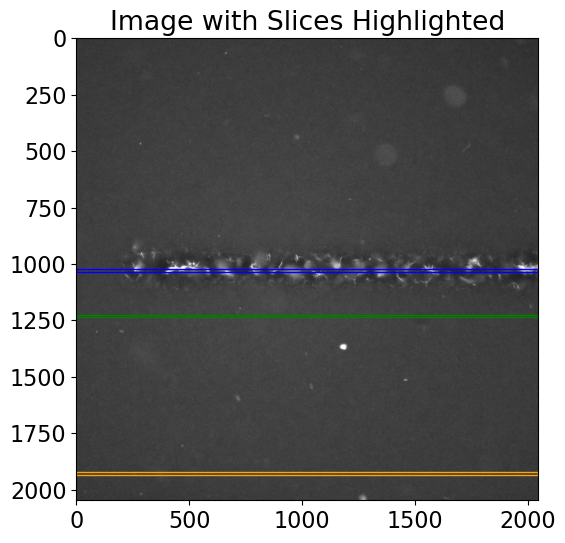

In [80]:
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_specific_frame(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)

    # Extract a horizontal slice in the middle of the image with a height of 10 pixels
    mid_height = image_np.shape[0] // 2
    slice_height = 10
    horizontal_slice = image_np[mid_height:mid_height + slice_height, :]
    mean_intensity_values_mid = horizontal_slice.mean(axis=0)

    # Extract another horizontal slice 200 pixels down from the middle
    offset_200 = 200
    if mid_height + offset_200 + slice_height < image_np.shape[0]:
        horizontal_slice_200_down = image_np[mid_height + offset_200:mid_height + offset_200 + slice_height, :]
        mean_intensity_values_200_down = horizontal_slice_200_down.mean(axis=0)
    else:
        raise ValueError("The image is not tall enough to extract a slice 200 pixels down from the middle.")

    # Extract another horizontal slice 800 pixels down from the middle
    offset_800 = 900
    if mid_height + offset_800 + slice_height < image_np.shape[0]:
        horizontal_slice_800_down = image_np[mid_height + offset_800:mid_height + offset_800 + slice_height, :]
        mean_intensity_values_800_down = horizontal_slice_800_down.mean(axis=0)
    else:
        raise ValueError("The image is not tall enough to extract a slice 800 pixels down from the middle.")

    # Generate a uniform distribution of the same length based on the mean of the 800 pixels down slice
    uniform_distribution = np.full_like(mean_intensity_values_mid, np.mean(mean_intensity_values_800_down))

    # Plot the intensity values and the uniform distribution
    plt.figure(figsize=(12, 6))
    plt.plot(mean_intensity_values_mid, label='Mid Slice Intensity', color='blue')
    plt.plot(mean_intensity_values_200_down, label='200 Pixels Down Slice Intensity', color='green')
    plt.plot(mean_intensity_values_800_down, label='900 Pixels Down Slice Intensity', color='orange')
    plt.plot(uniform_distribution, label='Uniform Distribution', color='red', linestyle='--')
    plt.xlabel('Pixel Position Across Width')
    plt.ylabel('Mean Intensity')
    plt.title('Comparison of Image Intensity and Uniform Distribution')
    plt.legend()
    plt.show()

    # Increase the intensity of the image for display
    scaling_factor = 0.3  # You can adjust this factor to increase or decrease brightness
    image_np_display = np.clip(image_np * scaling_factor, 0, 255).astype(np.uint8)

    # Plot the whole image and box up the slices
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(image_np_display, cmap='gray')

    # Add rectangles for the slices
    rect_mid = patches.Rectangle((0, mid_height), image_np.shape[1], slice_height, linewidth=1, edgecolor='blue', facecolor='none')
    rect_200 = patches.Rectangle((0, mid_height + offset_200), image_np.shape[1], slice_height, linewidth=1, edgecolor='green', facecolor='none')
    rect_800 = patches.Rectangle((0, mid_height + offset_800), image_np.shape[1], slice_height, linewidth=1, edgecolor='orange', facecolor='none')

    ax.add_patch(rect_mid)
    ax.add_patch(rect_200)
    ax.add_patch(rect_800)

    plt.title('Image with Slices Highlighted')
    plt.show()

# Assuming the base path is correctly set
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = sorted([f for f in os.listdir(base_folder) if 'correlation' in f], key=natural_sort_key)

# Select the first folder and get its path
if experiment_folders:
    first_exp_folder = experiment_folders[0]
    exp_folder_path = os.path.join(base_folder, first_exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]
    if pos_folders:
        first_pos_folder = pos_folders[0]
        tiff_files = sorted([f for f in os.listdir(first_pos_folder) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
        if len(tiff_files) > 19:  # Ensure there is at least 20 files
            tiff_file_path = os.path.join(first_pos_folder, tiff_files[19])  # 20th file
            process_specific_frame(tiff_file_path)
        else:
            print("Not enough TIFF files in the folder to process the 20th frame.")
    else:
        print("No position folders found.")
else:
    print("No experiment folders found.")


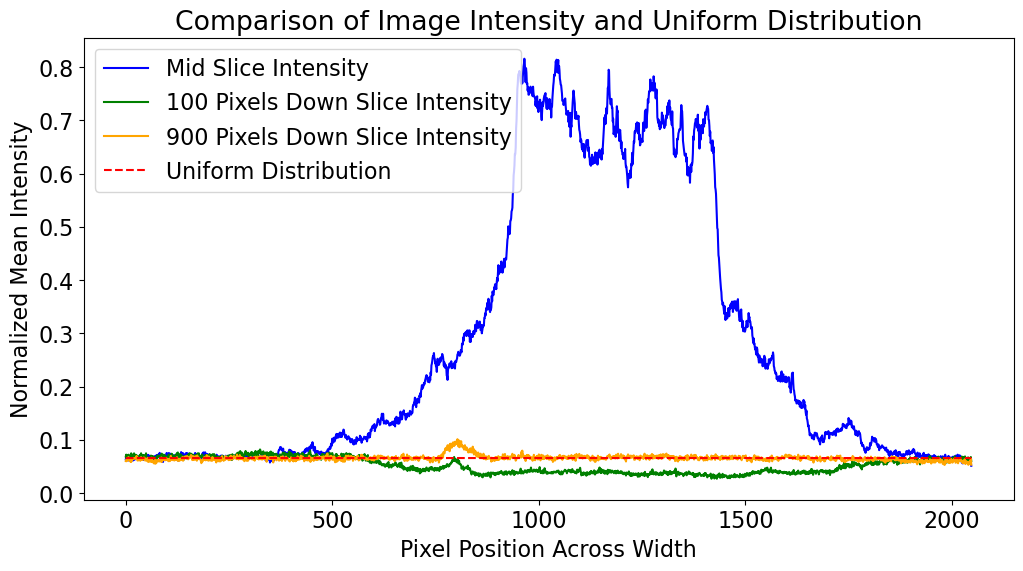

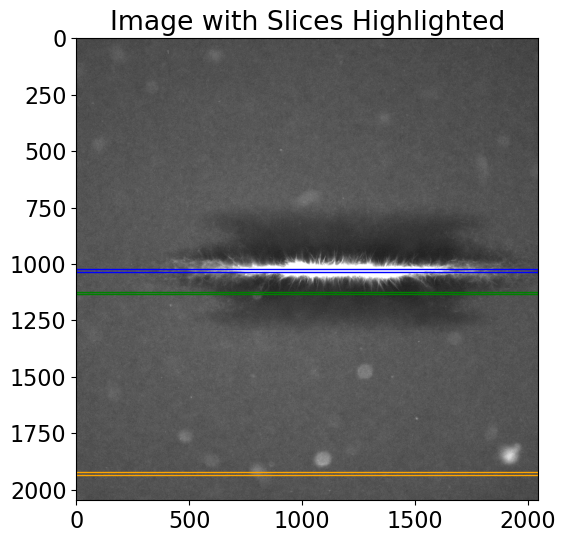

In [75]:
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def normalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def process_specific_frame(image_path, offset_200, offset_800, scaling_factor=5):
    image = Image.open(image_path)
    image_np = np.array(image)

    # Normalize the entire image between 0 and 1
    image_np_normalized = normalize(image_np)

    # Extract a horizontal slice in the middle of the image with a height of 10 pixels
    mid_height = image_np_normalized.shape[0] // 2
    slice_height = 10
    horizontal_slice = image_np_normalized[mid_height:mid_height + slice_height, :]
    mean_intensity_values_mid = horizontal_slice.mean(axis=0)

    # Extract another horizontal slice offset_200 pixels down from the middle
    if mid_height + offset_200 + slice_height < image_np_normalized.shape[0]:
        horizontal_slice_200_down = image_np_normalized[mid_height + offset_200:mid_height + offset_200 + slice_height, :]
        mean_intensity_values_200_down = horizontal_slice_200_down.mean(axis=0)
    else:
        raise ValueError(f"The image is not tall enough to extract a slice {offset_200} pixels down from the middle.")

    # Extract another horizontal slice offset_800 pixels down from the middle
    if mid_height + offset_800 + slice_height < image_np_normalized.shape[0]:
        horizontal_slice_800_down = image_np_normalized[mid_height + offset_800:mid_height + offset_800 + slice_height, :]
        mean_intensity_values_800_down = horizontal_slice_800_down.mean(axis=0)
    else:
        raise ValueError(f"The image is not tall enough to extract a slice {offset_800} pixels down from the middle.")

    # Generate a uniform distribution of the same length based on the mean of the 800 pixels down slice
    uniform_distribution = np.full_like(mean_intensity_values_mid, np.mean(mean_intensity_values_800_down))

    # Plot the intensity values and the uniform distribution
    plt.figure(figsize=(12, 6))
    plt.plot(mean_intensity_values_mid, label='Mid Slice Intensity', color='blue')
    plt.plot(mean_intensity_values_200_down, label=f'{offset_200} Pixels Down Slice Intensity', color='green')
    plt.plot(mean_intensity_values_800_down, label=f'{offset_800} Pixels Down Slice Intensity', color='orange')
    plt.plot(uniform_distribution, label='Uniform Distribution', color='red', linestyle='--')
    plt.xlabel('Pixel Position Across Width')
    plt.ylabel('Normalized Mean Intensity')
    plt.title('Comparison of Image Intensity and Uniform Distribution')
    plt.legend()
    plt.show()

    # Increase the intensity of the image for display
    image_np_display = np.clip(image_np_normalized * scaling_factor, 0, 1)

    # Plot the whole image and box up the slices
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(image_np_display, cmap='gray')

    # Add rectangles for the slices
    rect_mid = patches.Rectangle((0, mid_height), image_np.shape[1], slice_height, linewidth=1, edgecolor='blue', facecolor='none')
    rect_200 = patches.Rectangle((0, mid_height + offset_200), image_np.shape[1], slice_height, linewidth=1, edgecolor='green', facecolor='none')
    rect_800 = patches.Rectangle((0, mid_height + offset_800), image_np.shape[1], slice_height, linewidth=1, edgecolor='orange', facecolor='none')

    ax.add_patch(rect_mid)
    ax.add_patch(rect_200)
    ax.add_patch(rect_800)

    plt.title('Image with Slices Highlighted')
    plt.show()

# Assuming the base path is correctly set
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = sorted([f for f in os.listdir(base_folder) if 'correlation' in f], key=natural_sort_key)

# Select the first folder and get its path
if experiment_folders:
    first_exp_folder = experiment_folders[5]
    exp_folder_path = os.path.join(base_folder, first_exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]
    if pos_folders:
        first_pos_folder = pos_folders[0]
        tiff_files = sorted([f for f in os.listdir(first_pos_folder) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
        if len(tiff_files) > 19:  # Ensure there is at least 20 files
            tiff_file_path = os.path.join(first_pos_folder, tiff_files[19])  # 20th file
            process_specific_frame(tiff_file_path, offset_200=100, offset_800=900, scaling_factor=5)
        else:
            print("Not enough TIFF files in the folder to process the 20th frame.")
    else:
        print("No position folders found.")
else:
    print("No experiment folders found.")


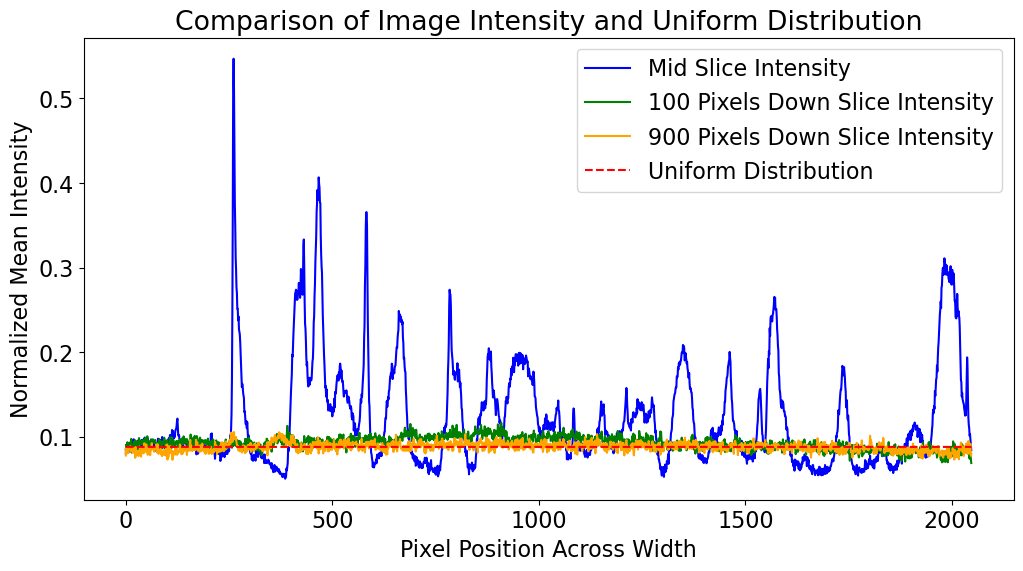

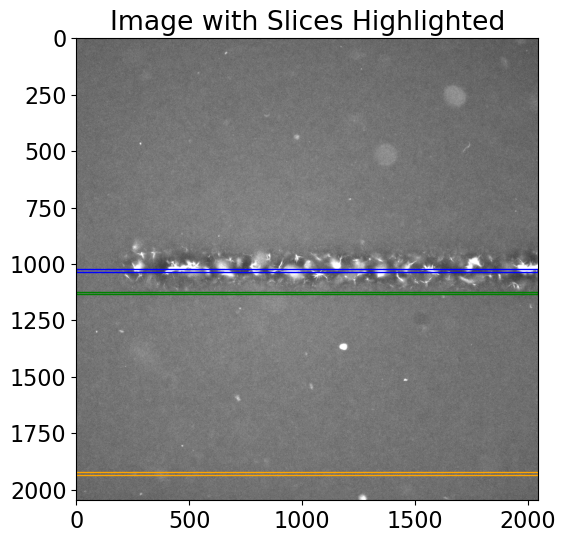

In [76]:
# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def normalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def process_specific_frame(image_path, offset_200, offset_800, scaling_factor=5):
    image = Image.open(image_path)
    image_np = np.array(image)

    # Normalize the entire image between 0 and 1
    image_np_normalized = normalize(image_np)

    # Extract a horizontal slice in the middle of the image with a height of 10 pixels
    mid_height = image_np_normalized.shape[0] // 2
    slice_height = 10
    horizontal_slice = image_np_normalized[mid_height:mid_height + slice_height, :]
    mean_intensity_values_mid = horizontal_slice.mean(axis=0)

    # Extract another horizontal slice offset_200 pixels down from the middle
    if mid_height + offset_200 + slice_height < image_np_normalized.shape[0]:
        horizontal_slice_200_down = image_np_normalized[mid_height + offset_200:mid_height + offset_200 + slice_height, :]
        mean_intensity_values_200_down = horizontal_slice_200_down.mean(axis=0)
    else:
        raise ValueError(f"The image is not tall enough to extract a slice {offset_200} pixels down from the middle.")

    # Extract another horizontal slice offset_800 pixels down from the middle
    if mid_height + offset_800 + slice_height < image_np_normalized.shape[0]:
        horizontal_slice_800_down = image_np_normalized[mid_height + offset_800:mid_height + offset_800 + slice_height, :]
        mean_intensity_values_800_down = horizontal_slice_800_down.mean(axis=0)
    else:
        raise ValueError(f"The image is not tall enough to extract a slice {offset_800} pixels down from the middle.")

    # Generate a uniform distribution of the same length based on the mean of the 800 pixels down slice
    uniform_distribution = np.full_like(mean_intensity_values_mid, np.mean(mean_intensity_values_800_down))

    # Plot the intensity values and the uniform distribution
    plt.figure(figsize=(12, 6))
    plt.plot(mean_intensity_values_mid, label='Mid Slice Intensity', color='blue')
    plt.plot(mean_intensity_values_200_down, label=f'{offset_200} Pixels Down Slice Intensity', color='green')
    plt.plot(mean_intensity_values_800_down, label=f'{offset_800} Pixels Down Slice Intensity', color='orange')
    plt.plot(uniform_distribution, label='Uniform Distribution', color='red', linestyle='--')
    plt.xlabel('Pixel Position Across Width')
    plt.ylabel('Normalized Mean Intensity')
    plt.title('Comparison of Image Intensity and Uniform Distribution')
    plt.legend()
    plt.show()

    # Increase the intensity of the image for display
    image_np_display = np.clip(image_np_normalized * scaling_factor, 0, 1)

    # Plot the whole image and box up the slices
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(image_np_display, cmap='gray')

    # Add rectangles for the slices
    rect_mid = patches.Rectangle((0, mid_height), image_np.shape[1], slice_height, linewidth=1, edgecolor='blue', facecolor='none')
    rect_200 = patches.Rectangle((0, mid_height + offset_200), image_np.shape[1], slice_height, linewidth=1, edgecolor='green', facecolor='none')
    rect_800 = patches.Rectangle((0, mid_height + offset_800), image_np.shape[1], slice_height, linewidth=1, edgecolor='orange', facecolor='none')

    ax.add_patch(rect_mid)
    ax.add_patch(rect_200)
    ax.add_patch(rect_800)

    plt.title('Image with Slices Highlighted')
    plt.show()

# Assuming the base path is correctly set
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = sorted([f for f in os.listdir(base_folder) if 'correlation' in f], key=natural_sort_key)

# Select the first folder and get its path
if experiment_folders:
    first_exp_folder = experiment_folders[0]
    exp_folder_path = os.path.join(base_folder, first_exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]
    if pos_folders:
        first_pos_folder = pos_folders[0]
        tiff_files = sorted([f for f in os.listdir(first_pos_folder) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
        if len(tiff_files) > 19:  # Ensure there is at least 20 files
            tiff_file_path = os.path.join(first_pos_folder, tiff_files[19])  # 20th file
            process_specific_frame(tiff_file_path, offset_200=100, offset_800=900, scaling_factor=5)
        else:
            print("Not enough TIFF files in the folder to process the 20th frame.")
    else:
        print("No position folders found.")
else:
    print("No experiment folders found.")


Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_170_min_no_6.1_1/Pos2
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos1
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0
Processing folder: /Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos2
Processing folder: /Users/scliu

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/3582381595.py:149: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in df.groupby(['Incubation Time']):
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/3582381595.py:158: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in df.groupby(['Incubation Time']):
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_97504/3582381595.py:167: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid thi

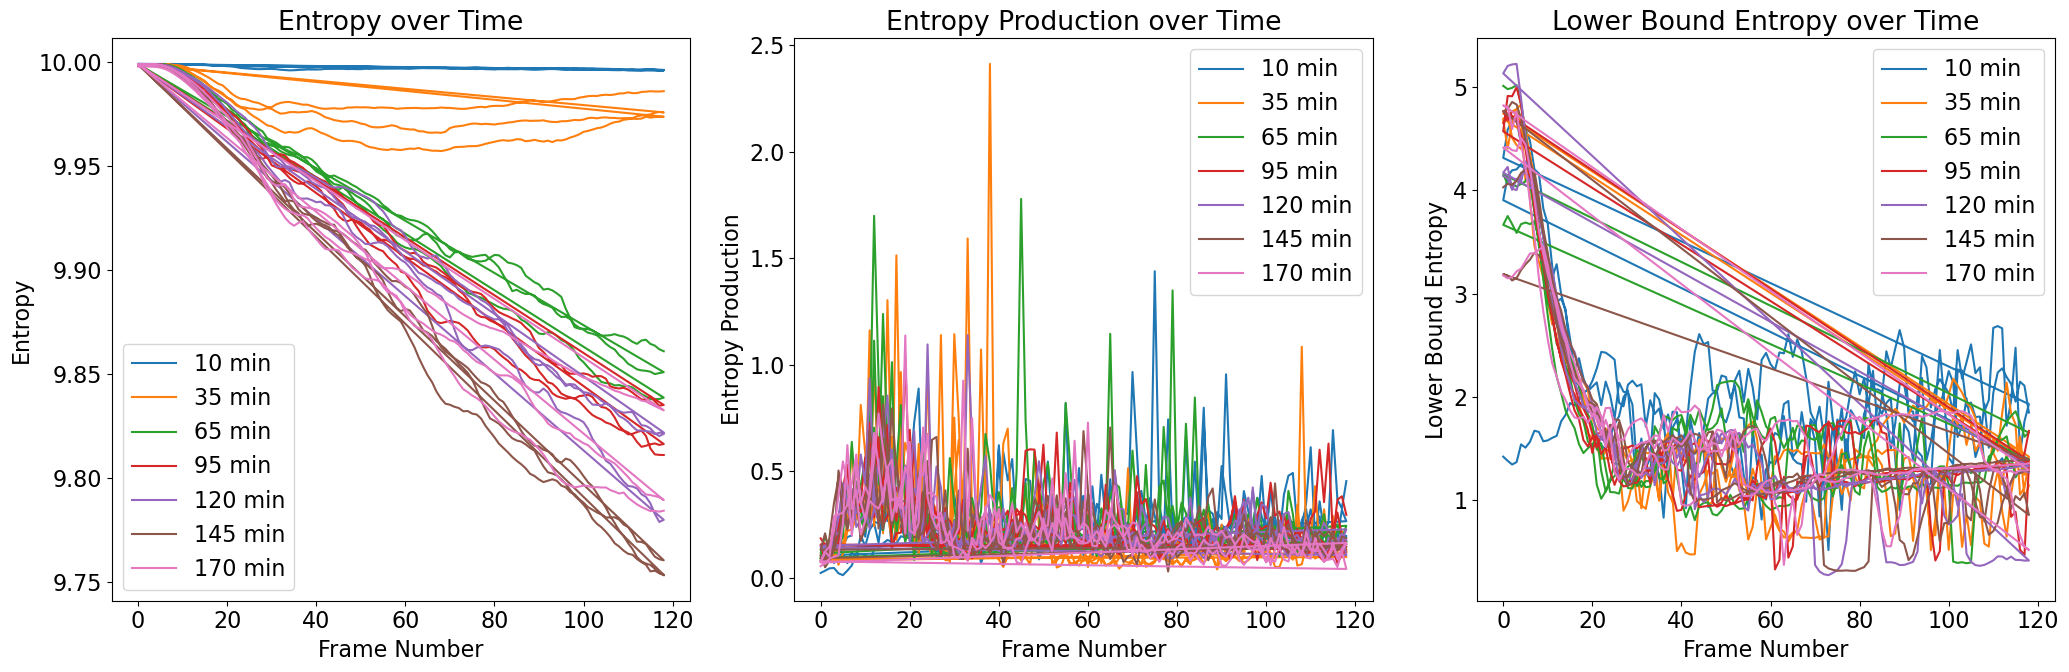

In [81]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Calculate the probability distribution with a small epsilon
def calculate_probability_distribution(image_np, grid_size=(32, 32), num_bins=100, epsilon=1e-8):
    height, width = image_np.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    intensity_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image_np[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            intensity_values.append(mean_intensity)

    intensity_values = np.array(intensity_values)
    hist, bin_edges = np.histogram(intensity_values, bins=num_bins, density=True)
    probability_distribution = hist * np.diff(bin_edges)
    
    # Add epsilon to avoid zero probabilities
    probability_distribution += epsilon
    # Normalize to ensure it sums to 1
    probability_distribution /= np.sum(probability_distribution)
    
    return probability_distribution

# Calculate entropy for grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum()
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))
    return entropy

# Calculate lower bound for entropy using mean and standard deviation
def calculate_entropy_lower_bound(intensity_values):
    mean_intensity = np.mean(intensity_values)
    std_intensity = np.std(intensity_values)
    
    # Normal distribution approximation for lower bound
    num_bins = 100
    hist, bin_edges = np.histogram(intensity_values, bins=num_bins, density=True)
    probability_distribution = hist * np.diff(bin_edges)
    
    # Add epsilon to avoid zero probabilities
    epsilon = 1e-8
    probability_distribution += epsilon
    probability_distribution /= np.sum(probability_distribution)
    
    entropy = -np.sum(probability_distribution * np.log2(probability_distribution + epsilon))
    
    return entropy

# Process each image sequence and return entropy and probability distributions
def process_image_sequence(tiff_folder_path):
    # Get and sort tiff files
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []
    probability_distributions = []
    lower_bounds = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        # Calculate entropy
        entropy = calculate_grid_entropy(image_np)
        entropy_over_time.append(entropy)
        
        # Calculate probability distribution
        prob_dist = calculate_probability_distribution(image_np)
        probability_distributions.append(prob_dist)
        
        # Calculate lower bound
        lower_bound = calculate_entropy_lower_bound(image_np.flatten())
        lower_bounds.append(lower_bound)
    
    return entropy_over_time, probability_distributions, lower_bounds

# Calculate local entropy production from probability distributions
def calculate_local_entropy_production(prob_dists):
    entropy_production = []
    for t in range(1, len(prob_dists)):
        p_t = prob_dists[t-1]
        p_t1 = prob_dists[t]
        entropy_production.append(np.sum(p_t1 * np.log(p_t1 / (p_t + np.finfo(float).eps))))
    return np.array(entropy_production)

# Assuming base_path is the directory containing your 'posX' folders
base_folder = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104'
experiment_folders = [f for f in os.listdir(base_folder) if 'correlation' in f]

video_data = []

for exp_folder in experiment_folders:
    # Extract incubation time from the experiment folder name
    incubation_time_str = exp_folder.split('_')[1]  # '10_min'
    incubation_time = int(incubation_time_str.split('_')[0])  # 10
    exp_folder_path = os.path.join(base_folder, exp_folder)
    pos_folders = [os.path.join(exp_folder_path, d) for d in os.listdir(exp_folder_path) if d.startswith('Pos')]

    for pos_folder in pos_folders:
        print(f"Processing folder: {pos_folder}")  # Print the current folder being processed
        entropy_over_time, prob_dists, lower_bounds = process_image_sequence(pos_folder)
        
        # Calculate entropy production
        entropy_production = calculate_local_entropy_production(prob_dists)

        for i, (entropy, entropy_prod, lower_bound) in enumerate(zip(entropy_over_time, entropy_production, lower_bounds)):
            video_data.append({
                'Frame Number': i,
                'Entropy': entropy,
                'Entropy Production': entropy_prod,
                'Lower Bound': lower_bound,
                'Incubation Time': incubation_time
            })

# Create DataFrame
df = pd.DataFrame(video_data)

# Plotting the results
plt.figure(figsize=(21, 7))

# Plot Entropy
plt.subplot(1, 3, 1)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Entropy'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# Plot Entropy Production
plt.subplot(1, 3, 2)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Entropy Production'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Production')
plt.title('Entropy Production over Time')
plt.legend()

# Plot Lower Bound
plt.subplot(1, 3, 3)
for key, grp in df.groupby(['Incubation Time']):
    plt.plot(grp['Frame Number'], grp['Lower Bound'], label=f'{key} min')
plt.xlabel('Frame Number')
plt.ylabel('Lower Bound Entropy')
plt.title('Lower Bound Entropy over Time')
plt.legend()

plt.tight_layout()
plt.show()


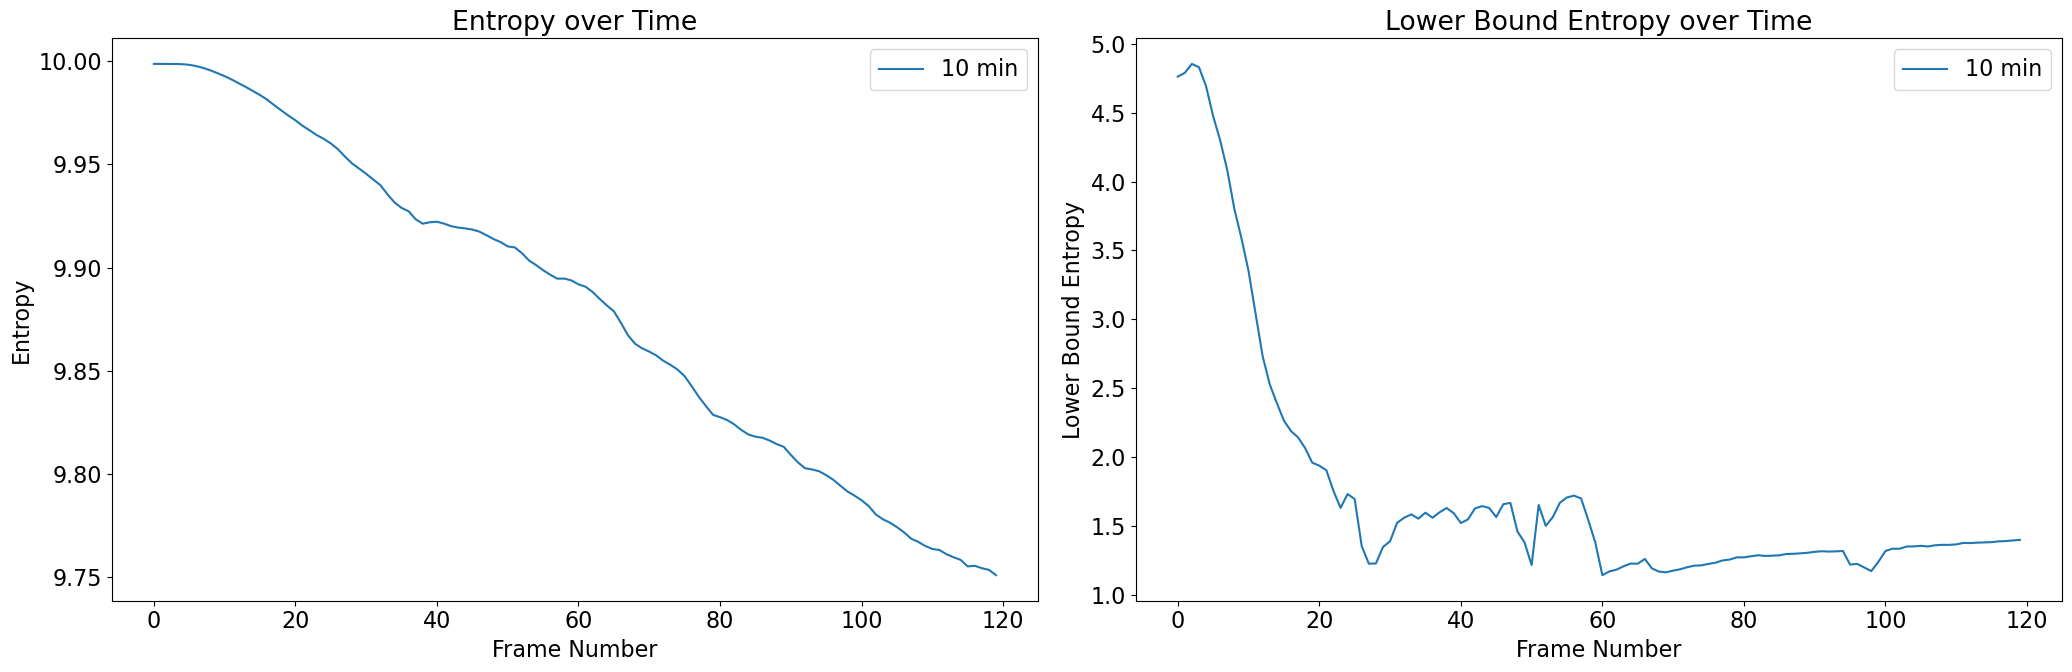

In [89]:
# Calculate the probability distribution with a small epsilon
def calculate_probability_distribution(image_np, grid_size=(32, 32), num_bins=1000, epsilon=1e-8):
    height, width = image_np.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    intensity_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image_np[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            intensity_values.append(mean_intensity)

    intensity_values = np.array(intensity_values)
    hist, bin_edges = np.histogram(intensity_values, bins=num_bins, density=True)
    probability_distribution = hist * np.diff(bin_edges)
    
    # Add epsilon to avoid zero probabilities
    probability_distribution += epsilon
    # Normalize to ensure it sums to 1
    probability_distribution /= np.sum(probability_distribution)
    
    return probability_distribution

# Calculate entropy for grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum()
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))
    return entropy

# Calculate lower bound for entropy using mean and standard deviation
def calculate_entropy_lower_bound(intensity_values):
    mean_intensity = np.mean(intensity_values)
    std_intensity = np.std(intensity_values)
    
    # Normal distribution approximation for lower bound
    num_bins = 100
    hist, bin_edges = np.histogram(intensity_values, bins=num_bins, density=True)
    probability_distribution = hist * np.diff(bin_edges)
    
    # Add epsilon to avoid zero probabilities
    epsilon = 1e-8
    probability_distribution += epsilon
    probability_distribution /= np.sum(probability_distribution)
    
    entropy = -np.sum(probability_distribution * np.log2(probability_distribution + epsilon))
    
    return entropy

# Process each image sequence and return entropy and probability distributions
def process_image_sequence(tiff_folder_path):
    # Get and sort tiff files
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []
    probability_distributions = []
    lower_bounds = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        # Calculate entropy
        entropy = calculate_grid_entropy(image_np)
        entropy_over_time.append(entropy)
        
        # Calculate probability distribution
        prob_dist = calculate_probability_distribution(image_np)
        probability_distributions.append(prob_dist)
        
        # Calculate lower bound
        lower_bound = calculate_entropy_lower_bound(image_np.flatten())
        lower_bounds.append(lower_bound)
    
    return entropy_over_time, probability_distributions, lower_bounds

# Process a single folder
single_folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_145_min_no_6.1_1/Pos0'
entropy_over_time, prob_dists, lower_bounds = process_image_sequence(single_folder_path)

# Prepare the data for plotting
video_data = []
for i, (entropy, lower_bound) in enumerate(zip(entropy_over_time, lower_bounds)):
    video_data.append({
        'Frame Number': i,
        'Entropy': entropy,
        'Lower Bound': lower_bound,
        'Incubation Time': 10  # Set to 10 as a placeholder
    })

# Create DataFrame
df = pd.DataFrame(video_data)

# Plotting the results
plt.figure(figsize=(21, 7))

# Plot Entropy
plt.subplot(1, 2, 1)
plt.plot(df['Frame Number'], df['Entropy'], label='10 min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# Plot Lower Bound
plt.subplot(1, 2, 2)
plt.plot(df['Frame Number'], df['Lower Bound'], label='10 min')
plt.xlabel('Frame Number')
plt.ylabel('Lower Bound Entropy')
plt.title('Lower Bound Entropy over Time')
plt.legend()

plt.tight_layout()
plt.show()


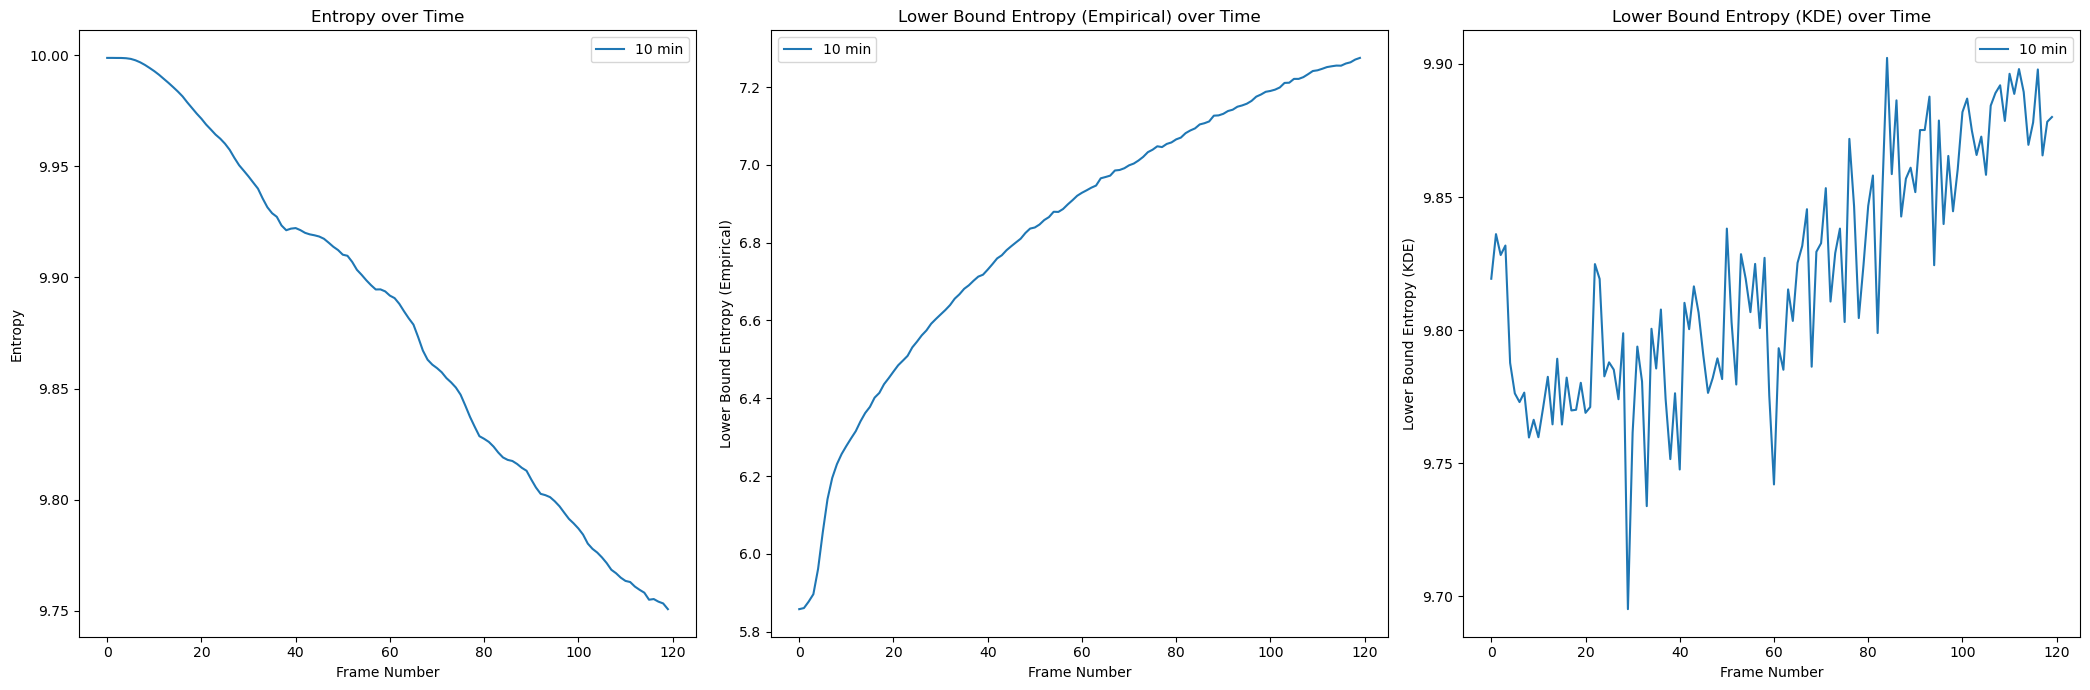

In [2]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Calculate the probability distribution without binning
def calculate_probability_distribution_no_binning(image_np, epsilon=1e-8):
    unique_values, counts = np.unique(image_np, return_counts=True)
    probability_distribution = counts / np.sum(counts)
    
    # Add epsilon to avoid zero probabilities
    probability_distribution += epsilon
    # Normalize to ensure it sums to 1
    probability_distribution /= np.sum(probability_distribution)
    
    return probability_distribution

# Calculate entropy for grid cells
def calculate_grid_entropy(image, grid_size=(32, 32)):
    height, width = image.shape[:2]
    cell_height, cell_width = height // grid_size[0], width // grid_size[1]
    entropy_values = []

    for i in range(0, height, cell_height):
        for j in range(0, width, cell_width):
            cell = image[i:min(i+cell_height, height), j:min(j+cell_width, width)]
            mean_intensity = np.mean(cell)
            entropy_values.append(mean_intensity)

    entropy_values = np.array(entropy_values)
    entropy_values /= entropy_values.sum()
    entropy = -np.sum(entropy_values * np.log2(entropy_values + np.finfo(float).eps))
    return entropy

# Calculate lower bound for entropy using empirical distribution
def calculate_entropy_lower_bound_empirical(intensity_values, epsilon=1e-8):
    unique_values, counts = np.unique(intensity_values, return_counts=True)
    probability_distribution = counts / np.sum(counts)
    
    # Add epsilon to avoid zero probabilities
    probability_distribution += epsilon
    # Normalize to ensure it sums to 1
    probability_distribution /= np.sum(probability_distribution)
    
    entropy = -np.sum(probability_distribution * np.log2(probability_distribution + epsilon))
    return entropy

# Calculate lower bound for entropy using KDE with subsampling
def calculate_entropy_lower_bound_kde(intensity_values, subsample_size=1000, bandwidth=0.1, epsilon=1e-8):
    # Subsample the intensity values
    if len(intensity_values) > subsample_size:
        subsample_indices = np.random.choice(len(intensity_values), subsample_size, replace=False)
        subsample_values = intensity_values[subsample_indices]
    else:
        subsample_values = intensity_values
    
    kde = gaussian_kde(subsample_values, bw_method=bandwidth)
    density = kde(subsample_values)
    
    # Normalize the density to ensure it sums to 1
    density += epsilon
    density /= np.sum(density)
    
    entropy = -np.sum(density * np.log2(density + epsilon))
    return entropy

# Process each image sequence and return entropy and probability distributions
def process_image_sequence(tiff_folder_path):
    # Get and sort tiff files
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if f.endswith('_Cy5_000.tif')], key=natural_sort_key)
    entropy_over_time = []
    lower_bounds_empirical = []
    lower_bounds_kde = []

    for tiff_file in tiff_files:
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)

        # Apply a uniform filter to the image
        size = 8  # The size of the filtering window
        image_np = uniform_filter(image_np, size=size)
        
        # Calculate entropy
        entropy = calculate_grid_entropy(image_np)
        entropy_over_time.append(entropy)
        
        # Calculate lower bound using empirical distribution
        lower_bound_empirical = calculate_entropy_lower_bound_empirical(image_np.flatten())
        lower_bounds_empirical.append(lower_bound_empirical)
        
        # Calculate lower bound using KDE with subsampling
        lower_bound_kde = calculate_entropy_lower_bound_kde(image_np.flatten())
        lower_bounds_kde.append(lower_bound_kde)
    
    return entropy_over_time, lower_bounds_empirical, lower_bounds_kde

# Process a single folder
entropy_over_time, lower_bounds_empirical, lower_bounds_kde = process_image_sequence(single_folder_path)

# Prepare the data for plotting
video_data = []
for i, (entropy, lower_bound_empirical, lower_bound_kde) in enumerate(zip(entropy_over_time, lower_bounds_empirical, lower_bounds_kde)):
    video_data.append({
        'Frame Number': i,
        'Entropy': entropy,
        'Lower Bound Empirical': lower_bound_empirical,
        'Lower Bound KDE': lower_bound_kde,
        'Incubation Time': 10  # Set to 10 as a placeholder
    })

# Create DataFrame
df = pd.DataFrame(video_data)

# Plotting the results
plt.figure(figsize=(21, 7))

# Plot Entropy
plt.subplot(1, 3, 1)
plt.plot(df['Frame Number'], df['Entropy'], label='10 min')
plt.xlabel('Frame Number')
plt.ylabel('Entropy')
plt.title('Entropy over Time')
plt.legend()

# Plot Lower Bound Empirical
plt.subplot(1, 3, 2)
plt.plot(df['Frame Number'], df['Lower Bound Empirical'], label='10 min')
plt.xlabel('Frame Number')
plt.ylabel('Lower Bound Entropy (Empirical)')
plt.title('Lower Bound Entropy (Empirical) over Time')
plt.legend()

# Plot Lower Bound KDE
plt.subplot(1, 3, 3)
plt.plot(df['Frame Number'], df['Lower Bound KDE'], label='10 min')
plt.xlabel('Frame Number')
plt.ylabel('Lower Bound Entropy (KDE)')
plt.title('Lower Bound Entropy (KDE) over Time')
plt.legend()

plt.tight_layout()
plt.show()


In [65]:
folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/supplemental/calibration'


In [79]:
import os
import re
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def load_images(folder_path):
    images = {}
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".tif") or file.endswith(".tiff"):
                concentration = os.path.basename(root)
                image_path = os.path.join(root, file)
                image = tiff.imread(image_path)
                if concentration not in images:
                    images[concentration] = []
                images[concentration].append(image)
    return images

def subtract_background(images, blank_images):
    if not blank_images:
        print("No blank images available for background subtraction.")
        return images
    
    for concentration, image_list in images.items():
        for i in range(len(image_list)):
            blank_image = blank_images[i % len(blank_images)]
            image_list[i] = image_list[i] - blank_image
    return images

def calculate_average_intensity(images):
    average_intensities = {}
    for concentration, image_list in images.items():
        if image_list:  # Check if the list is not empty
            avg_intensity = np.mean([np.mean(image) for image in image_list])
            avg_concentration = float(concentration.split('_')[0])
            if avg_concentration not in average_intensities:
                average_intensities[avg_concentration] = []
            average_intensities[avg_concentration].append(avg_intensity)
        else:
            print(f"No images found for concentration: {concentration}")
    return average_intensities

def calculate_blank_intensity(blank_images):
    if not blank_images:
        print("No blank images available to calculate blank intensity.")
        return 0
    blank_intensities = [np.mean(image) for image in blank_images]
    avg_blank_intensity = np.mean(blank_intensities)
    print(f"Average intensity for blank images: {avg_blank_intensity}")
    return avg_blank_intensity

def print_average_intensities(average_intensities):
    sorted_concentrations = sorted(average_intensities.keys(), reverse=True)
    for concentration in sorted_concentrations:
        avg_intensity = np.mean(average_intensities[concentration])
        print(f"Average intensity for {concentration*100}%: {avg_intensity}")

def convert_to_mt_per_um2(concentrations):
    conversion_factor = reference_value / reference_concentration  # 1 MT/um² per 0.0179%
    mt_per_um2 = {conc: conc * conversion_factor for conc in concentrations}
    return mt_per_um2

# Parameters
reference_concentration = 0.0179  # 0.0179% is the reference concentration
reference_value = 1.0  # MT/um²

# Folder path (you need to set this to your folder path)

# Load images
images = load_images(folder_path)

# Identify blank images
blank_keys = [key for key in images.keys() if 'blank' in key.lower()]
blank_images = []
for blank_key in blank_keys:
    blank_images.extend(images[blank_key])

images = {k: v for k, v in images.items() if k not in blank_keys}

# Subtract background
images = subtract_background(images, blank_images)

# Calculate average intensities
average_intensities = calculate_average_intensity(images)

# Calculate and print blank intensity
calculate_blank_intensity(blank_images)

# Print average intensities for each concentration
print_average_intensities(average_intensities)

# Convert concentrations to MT/um²
mt_per_um2 = convert_to_mt_per_um2(average_intensities.keys())

# Prepare data for plotting
mt_densities = [mt_per_um2[c] for c in sorted(average_intensities.keys(), reverse=True)]
intensities = [np.mean(average_intensities[c]) for c in sorted(average_intensities.keys(), reverse=True)]

# Plotting the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(mt_densities, intensities, 'o-', label='Data points')
plt.xlabel('MT density (MT/um²)')
plt.ylabel('Average Intensity')
plt.title('Calibration Curve: MT Density vs. Average Intensity')
plt.legend()
plt.grid(True)
plt.show()


No blank images available for background subtraction.


ValueError: could not convert string to float: 'Pos0'

Calibration curve equation: Average Intensity = 143.05 * MT Density + -39.76


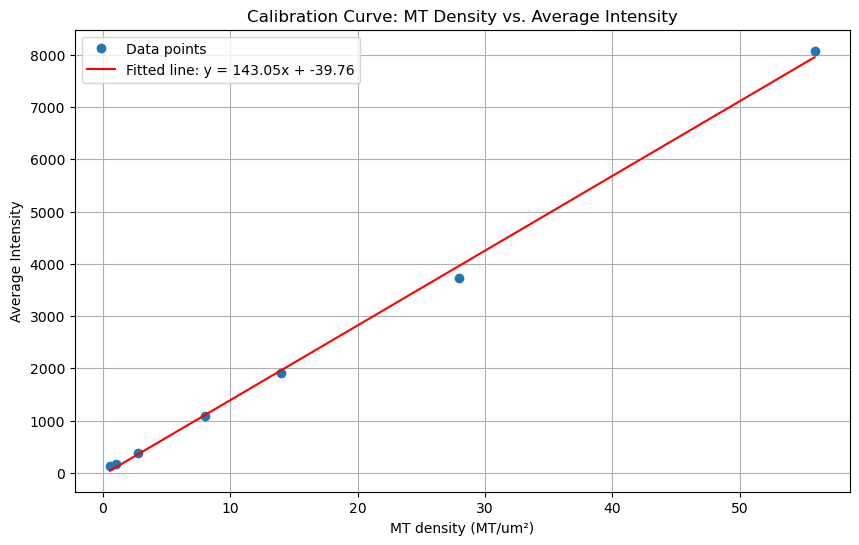

In [ ]:
# Prepare the data
mt_densities = np.array(mt_densities).reshape(-1, 1)
intensities = np.array(intensities)

# Fit a linear regression model
model = LinearRegression()
model.fit(mt_densities, intensities)

# Get the slope and intercept of the fitted line
slope = model.coef_[0]
intercept = model.intercept_

# Print the equation of the line
print(f"Calibration curve equation: Average Intensity = {slope:.2f} * MT Density + {intercept:.2f}")

# Plot the data points and the fitted line
plt.figure(figsize=(10, 6))
plt.plot(mt_densities, intensities, 'o', label='Data points')
plt.plot(mt_densities, model.predict(mt_densities), 'r-', label=f'Fitted line: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('MT density (MT/um²)')
plt.ylabel('Average Intensity')
plt.title('Calibration Curve: MT Density vs. Average Intensity')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
tiff_folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0'


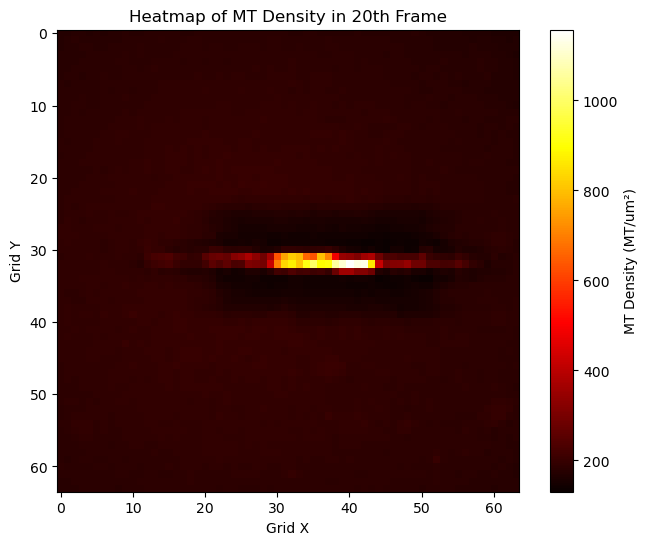

In [ ]:
# Constants
PIXEL_SIZE_UM = 0.43  # Pixel size in micrometers

# Function to sort filenames naturally
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Function to calculate microtubule density
def calculate_microtubule_density(image_np, calibration_factor):
    """Convert image intensity to microtubule number density."""
    return image_np * calibration_factor

# Function to process each image sequence and compute number of microtubules in each grid
def process_image_sequence(tiff_folder_path, grid_size=(32, 32)):
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if 'Cy5_' in f and f.endswith('.tif')], key=natural_sort_key)
    results = []

    # Determine the calibration factor from the first frame
    first_image_path = os.path.join(tiff_folder_path, tiff_files[0])
    first_image = Image.open(first_image_path)
    first_image_np = np.array(first_image)
    first_image_np = uniform_filter(first_image_np, size=8)
    average_intensity_first_frame = np.mean(first_image_np)
    calibration_factor = 1 / average_intensity_first_frame  # Normalize to 1 MT/um^2

    for i, tiff_file in enumerate(tiff_files):
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)
        
        # Apply uniform filter
        image_np = uniform_filter(image_np, size=8)
        
        height, width = image_np.shape
        cell_height, cell_width = grid_size
        mt_counts = []

        for y in range(0, height, cell_height):
            for x in range(0, width, cell_width):
                cell = image_np[y:y + cell_height, x:x + cell_width]
                mt_density = calculate_microtubule_density(cell, calibration_factor)
                mt_count = np.sum(mt_density) * (PIXEL_SIZE_UM ** 2)  # Convert density to count
                mt_counts.append(mt_count)

        results.append({
            'Frame': i,
            'MT_Counts': mt_counts
        })
    
    return results

# Path to the specific folder to process

# Process the image sequence
results = process_image_sequence(tiff_folder_path)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Extract the 20th frame data
frame_20_data = df.loc[df['Frame'] == 20, 'MT_Counts'].values[0]
grid_size = (32, 32)
grid_height = int(len(frame_20_data) ** 0.5)  # Assuming a square grid
grid_width = grid_height

# Reshape the data into a 2D array for the heatmap
frame_20_grid = np.array(frame_20_data).reshape(grid_height, grid_width)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(frame_20_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='MT Density (MT/um²)')
plt.title('Heatmap of MT Density in 20th Frame')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()


Bounding box coordinates: x=201, y=932, width=1847, height=182
Initial volume V_i: 62154.87 um^2


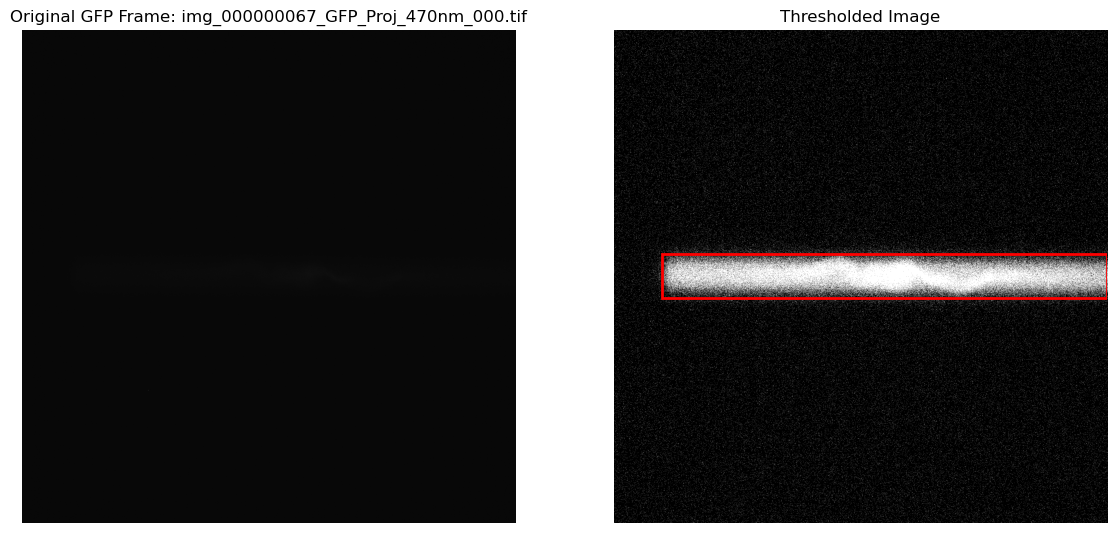

In [ ]:
# Constants
PIXEL_SIZE_UM = 0.43  # Pixel size in micrometers

# Function to load a random GFP frame
def load_random_gfp_frame(folder_path):
    gfp_files = [f for f in os.listdir(folder_path) if 'GFP' in f and f.endswith('.tif')]
    random_file = random.choice(gfp_files)
    image_path = os.path.join(folder_path, random_file)
    image = Image.open(image_path)
    return np.array(image), random_file

# Function to apply thresholding
def apply_threshold(image_np, threshold=100):
    """Apply a simple threshold to find the activated region."""
    binary_image = image_np > threshold
    return binary_image

# Function to find bounding box around the brightest region
def find_bounding_box(binary_image):
    contours, _ = cv2.findContours(binary_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return x, y, w, h
    return None

# Path to the folder containing the images
folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0'

# Load a random GFP frame
gfp_image_np, gfp_filename = load_random_gfp_frame(folder_path)

# Apply thresholding to find the activated region
thresholded_image = apply_threshold(gfp_image_np, threshold=108)  # Adjusted threshold for better accuracy

# Find the bounding box of the activated region
bounding_box = find_bounding_box(thresholded_image)

if bounding_box:
    x, y, w, h = bounding_box
    V_i = w * h * PIXEL_SIZE_UM**2  # Calculate the initial volume assuming a 2D area
    print(f"Bounding box coordinates: x={x}, y={y}, width={w}, height={h}")
    print(f"Initial volume V_i: {V_i:.2f} um^2")
else:
    print("No activated region found.")

# Plot the original GFP frame and thresholded image with bounding box
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title(f'Original GFP Frame: {gfp_filename}')
plt.imshow(gfp_image_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Thresholded Image')
plt.imshow(thresholded_image, cmap='gray')
plt.axis('off')

# Add bounding box to thresholded image
if bounding_box:
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))

plt.show()


Bounding box coordinates: x=197, y=931, width=1851, height=181
Initial volume V_i: 61947.23 um^2


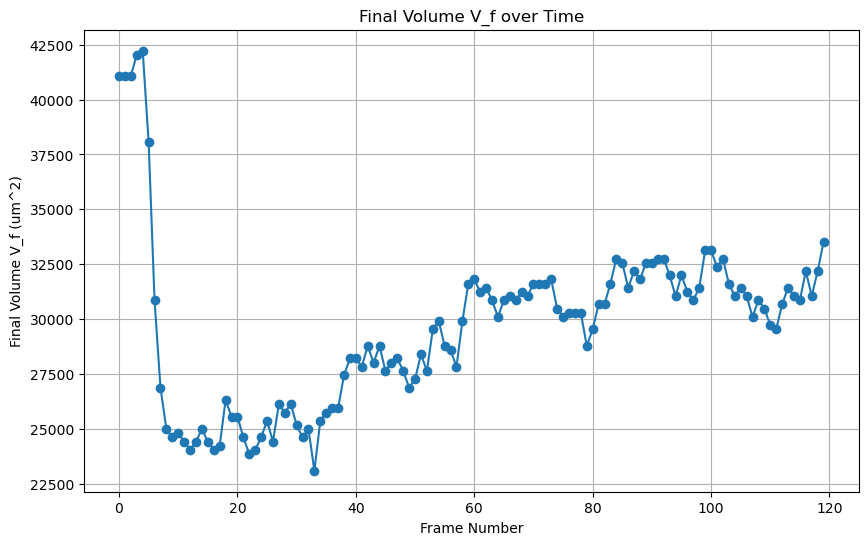

Final volume V_f for frame 4: 42222.28 um^2
Final volume V_f for frame 20: 25560.58 um^2


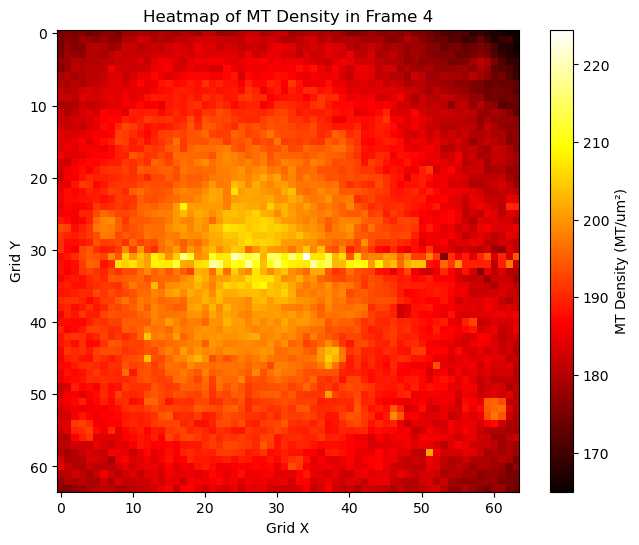

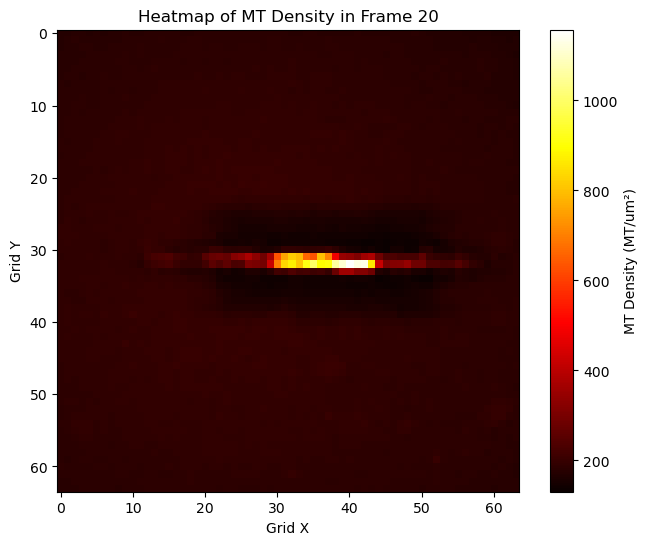

In [81]:


# Constants
PIXEL_SIZE_UM = 0.43  # Pixel size in micrometers
GRID_SIZE = (32, 32)  # Grid size
THRESHOLD_MT_DENSITY = 1  # Threshold for MT density in MT/um²

# Function to load a random GFP frame
def load_random_gfp_frame(folder_path):
    gfp_files = [f for f in os.listdir(folder_path) if 'GFP' in f and f.endswith('.tif')]
    random_file = random.choice(gfp_files)
    image_path = os.path.join(folder_path, random_file)
    image = Image.open(image_path)
    return np.array(image), random_file

# Function to apply thresholding
def apply_threshold(image_np, threshold=100):
    """Apply a simple threshold to find the activated region."""
    binary_image = image_np > threshold
    return binary_image

# Function to find bounding box around the brightest region
def find_bounding_box(binary_image):
    contours, _ = cv2.findContours(binary_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return x, y, w, h
    return None

# Load a random GFP frame
folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0'
gfp_image_np, gfp_filename = load_random_gfp_frame(folder_path)

# Apply thresholding to find the activated region
thresholded_image = apply_threshold(gfp_image_np, threshold=108)  # Adjusted threshold for better accuracy

# Find the bounding box of the activated region
bounding_box = find_bounding_box(thresholded_image)

if bounding_box:
    x, y, w, h = bounding_box
    V_i = w * h * PIXEL_SIZE_UM**2  # Calculate the initial volume assuming a 2D area
    print(f"Bounding box coordinates: x={x}, y={y}, width={w}, height={h}")
    print(f"Initial volume V_i: {V_i:.2f} um^2")
else:
    print("No activated region found.")
    V_i = None

# Function to calculate microtubule density
def calculate_microtubule_density(image_np, calibration_factor):
    """Convert image intensity to microtubule number density."""
    return image_np * calibration_factor

# Function to process each image sequence and compute number of microtubules in each grid
def process_image_sequence(tiff_folder_path, grid_size=(32, 32)):
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if 'Cy5_' in f and f.endswith('.tif')], key=natural_sort_key)
    results = []

    # Determine the calibration factor from the first frame
    first_image_path = os.path.join(tiff_folder_path, tiff_files[0])
    first_image = Image.open(first_image_path)
    first_image_np = np.array(first_image)
    first_image_np = uniform_filter(first_image_np, size=8)
    average_intensity_first_frame = np.mean(first_image_np)
    calibration_factor = 1 / average_intensity_first_frame  # Normalize to 1 MT/um^2

    for i, tiff_file in enumerate(tiff_files):
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)
        
        # Apply uniform filter
        image_np = uniform_filter(image_np, size=8)
        
        height, width = image_np.shape
        cell_height, cell_width = grid_size
        mt_counts = []

        for y in range(0, height, cell_height):
            for x in range(0, width, cell_width):
                cell = image_np[y:y + cell_height, x:x + cell_width]
                mt_density = calculate_microtubule_density(cell, calibration_factor)
                mt_count = np.sum(mt_density) * (PIXEL_SIZE_UM ** 2)  # Convert density to count
                mt_counts.append(mt_count)

        results.append({
            'Frame': i,
            'MT_Counts': mt_counts
        })
    
    return results

# Process the image sequence
results = process_image_sequence(folder_path)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Calculate V_f for each frame
def calculate_vf_in_bounding_box(mt_counts, threshold, pixel_size_um, grid_size, bounding_box):
    """Calculate the final volume V_f based on the threshold and bounding box."""
    x, y, w, h = bounding_box
    grid_cell_area_um2 = (grid_size[0] * pixel_size_um) * (grid_size[1] * pixel_size_um)
    V_f = 0
    
    grid_height = int(len(mt_counts) ** 0.5)  # Assuming a square grid
    grid_width = grid_height

    for grid_y in range(grid_height):
        for grid_x in range(grid_width):
            grid_index = grid_y * grid_width + grid_x
            grid_x_pos = grid_x * grid_size[0]
            grid_y_pos = grid_y * grid_size[1]
            
            if x <= grid_x_pos < x + w and y <= grid_y_pos < y + h:
                if mt_counts[grid_index] > threshold:
                    V_f += grid_cell_area_um2

    return V_f

V_f_list = []

for index, row in df.iterrows():
    mt_counts = row['MT_Counts']
    V_f = calculate_vf_in_bounding_box(mt_counts, threshold_count, PIXEL_SIZE_UM, GRID_SIZE, bounding_box)
    V_f_list.append(V_f)

df['V_f'] = V_f_list

# Plot V_f over time (frame number)
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['V_f'], 'o-')
plt.xlabel('Frame Number')
plt.ylabel('Final Volume V_f (um^2)')
plt.title('Final Volume V_f over Time')
plt.grid(True)
plt.show()

# Calculate and print V_f for frame 4 and frame 20
frame_4_data = df.loc[df['Frame'] == 4, 'MT_Counts'].values[0]
frame_20_data = df.loc[df['Frame'] == 20, 'MT_Counts'].values[0]

V_f_frame_4 = calculate_vf_in_bounding_box(frame_4_data, threshold_count, PIXEL_SIZE_UM, GRID_SIZE, bounding_box)
V_f_frame_20 = calculate_vf_in_bounding_box(frame_20_data, threshold_count, PIXEL_SIZE_UM, GRID_SIZE, bounding_box)

print(f"Final volume V_f for frame 4: {V_f_frame_4:.2f} um^2")
print(f"Final volume V_f for frame 20: {V_f_frame_20:.2f} um^2")

# Plot the MT density for frame 4 and frame 20
def plot_mt_density(frame_data, frame_number, grid_size=(32, 32)):
    grid_height = int(len(frame_data) ** 0.5)  # Assuming a square grid
    grid_width = grid_height

    # Reshape the data into a 2D array for the heatmap
    frame_grid = np.array(frame_data).reshape(grid_height, grid_width)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(frame_grid, cmap='hot', interpolation='nearest')
    plt.colorbar(label='MT Density (MT/um²)')
    plt.title(f'Heatmap of MT Density in Frame {frame_number}')
    plt.xlabel('Grid X')
    plt.ylabel('Grid Y')
    plt.show()

# Plot for frame 4
plot_mt_density(frame_4_data, 4)

# Plot for frame 20
plot_mt_density(frame_20_data, 20)


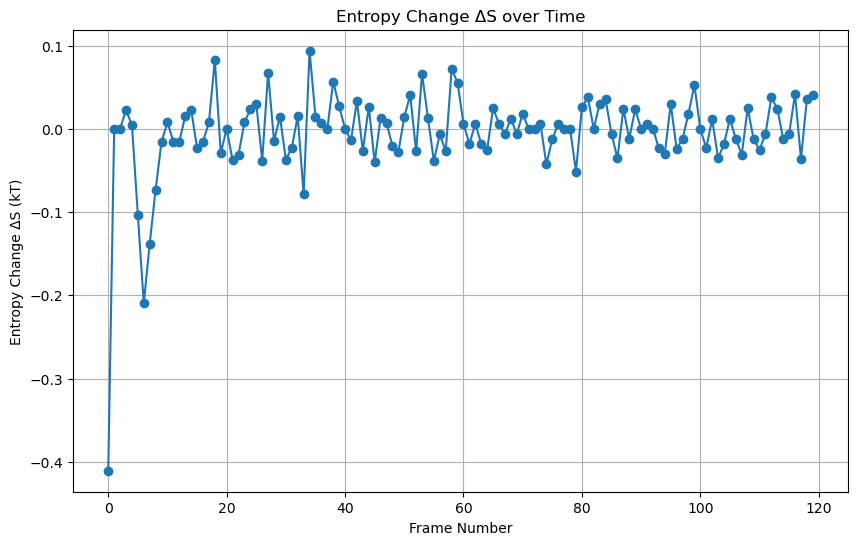

In [85]:
# Create a list V and initialize it with V_i
V = [V_i]

# Append each V_f to the list V
for vf in df['V_f']:
    V.append(vf)

# Calculate delta V for each frame
delta_V_list = [V[i + 1] - V[i] for i in range(len(V) - 1)]

# Add delta V to the DataFrame
df['Delta_V'] = delta_V_list

# Calculate delta S for each frame
delta_S_list = [np.log(V[i + 1] / V[i]) for i in range(len(V) - 1)]

# Add delta S to the DataFrame
df['Delta_S'] = delta_S_list

# Plot Delta S over time (frame number)
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['Delta_S'], 'o-')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Change ΔS (kT)')
plt.title('Entropy Change ΔS over Time')
plt.grid(True)
plt.show()




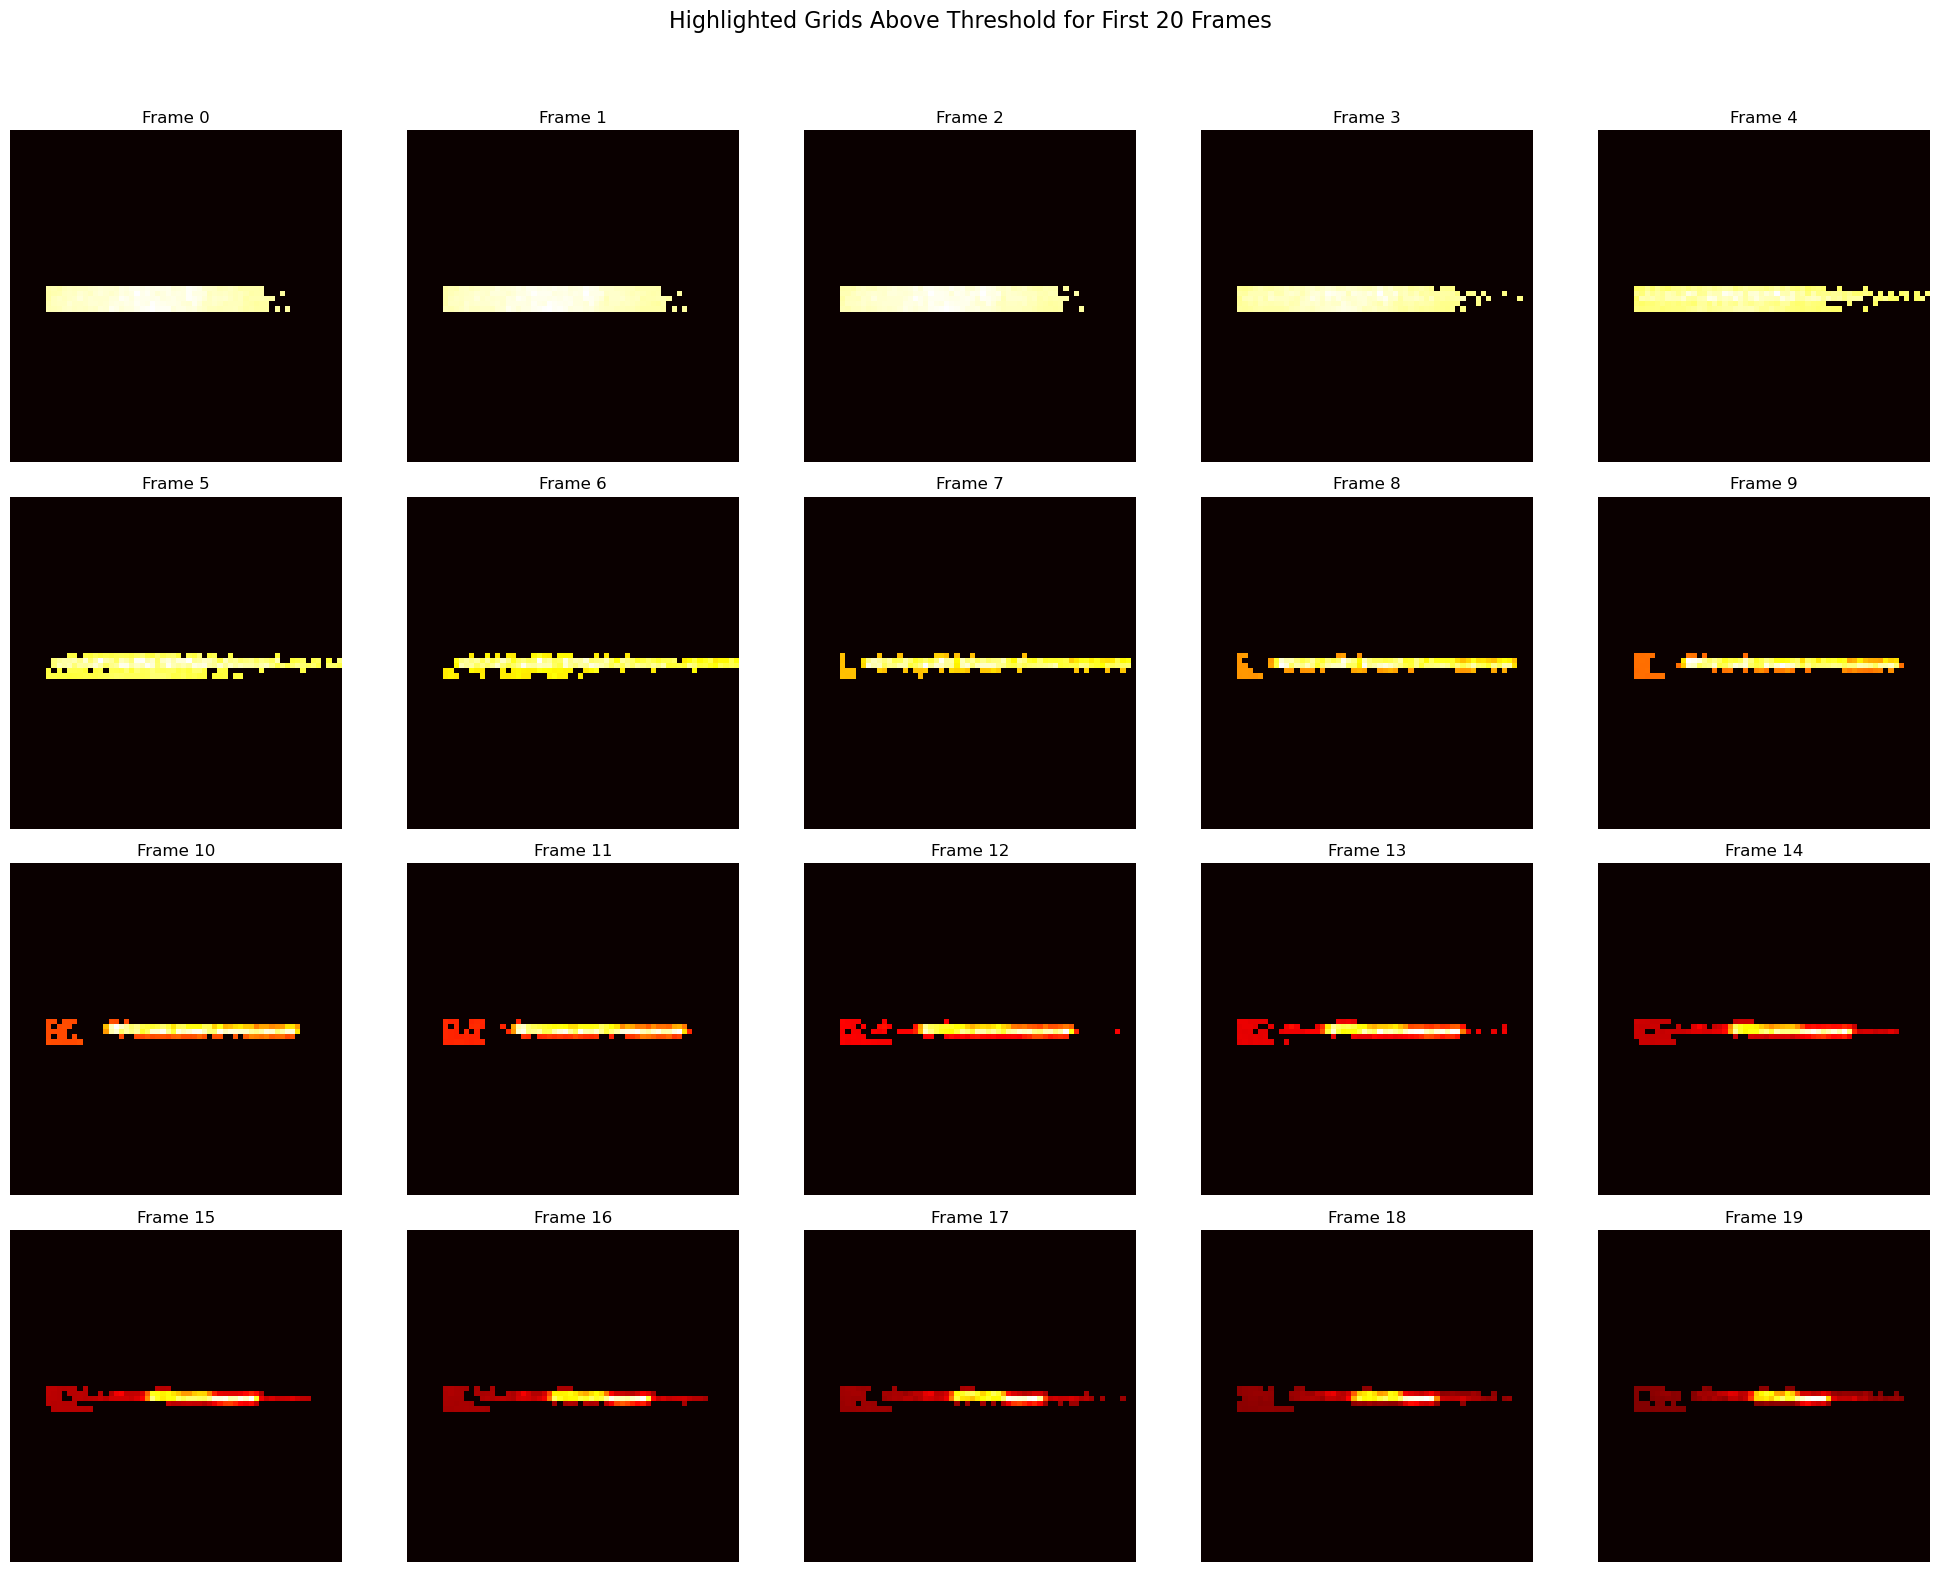

In [86]:
# Function to highlight grids above the threshold
def highlight_grids(frame_data, grid_size=(32, 32), threshold=1, bounding_box=None):
    grid_height = int(len(frame_data) ** 0.5)  # Assuming a square grid
    grid_width = grid_height

    # Reshape the data into a 2D array for the heatmap
    frame_grid = np.array(frame_data).reshape(grid_height, grid_width)

    highlighted_grid = np.zeros_like(frame_grid)
    
    if bounding_box:
        x, y, w, h = bounding_box
        for grid_y in range(grid_height):
            for grid_x in range(grid_width):
                grid_index = grid_y * grid_width + grid_x
                grid_x_pos = grid_x * grid_size[0]
                grid_y_pos = grid_y * grid_size[1]
                
                if x <= grid_x_pos < x + w and y <= grid_y_pos < y + h:
                    if frame_grid[grid_y, grid_x] > threshold:
                        highlighted_grid[grid_y, grid_x] = frame_grid[grid_y, grid_x]
                        
    return highlighted_grid

# Plot highlighted grids for the first 20 frames, 5 plots per row
num_frames_to_plot = 20
frames_to_plot = df['Frame'].iloc[:num_frames_to_plot]
nrows = 4
ncols = 5

plt.figure(figsize=(20, 16))

for i, frame_number in enumerate(frames_to_plot):
    plt.subplot(nrows, ncols, i + 1)
    frame_data = df.loc[df['Frame'] == frame_number, 'MT_Counts'].values[0]
    highlighted_grid = highlight_grids(frame_data, GRID_SIZE, threshold_count, bounding_box)
    plt.imshow(highlighted_grid, cmap='hot', interpolation='nearest')
    plt.title(f'Frame {frame_number}')
    plt.axis('off')

plt.suptitle('Highlighted Grids Above Threshold for First 20 Frames', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Initial volume V_i: 775526.81 um^2


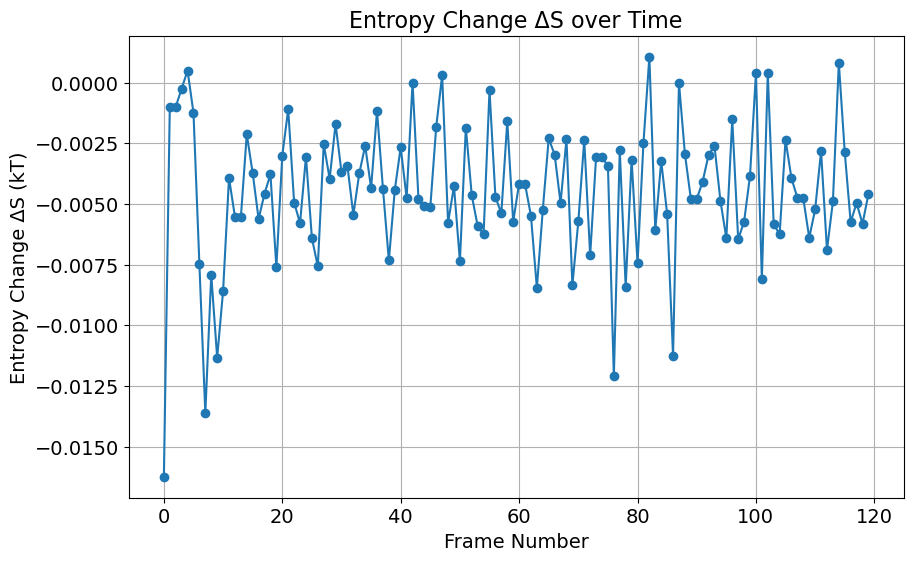

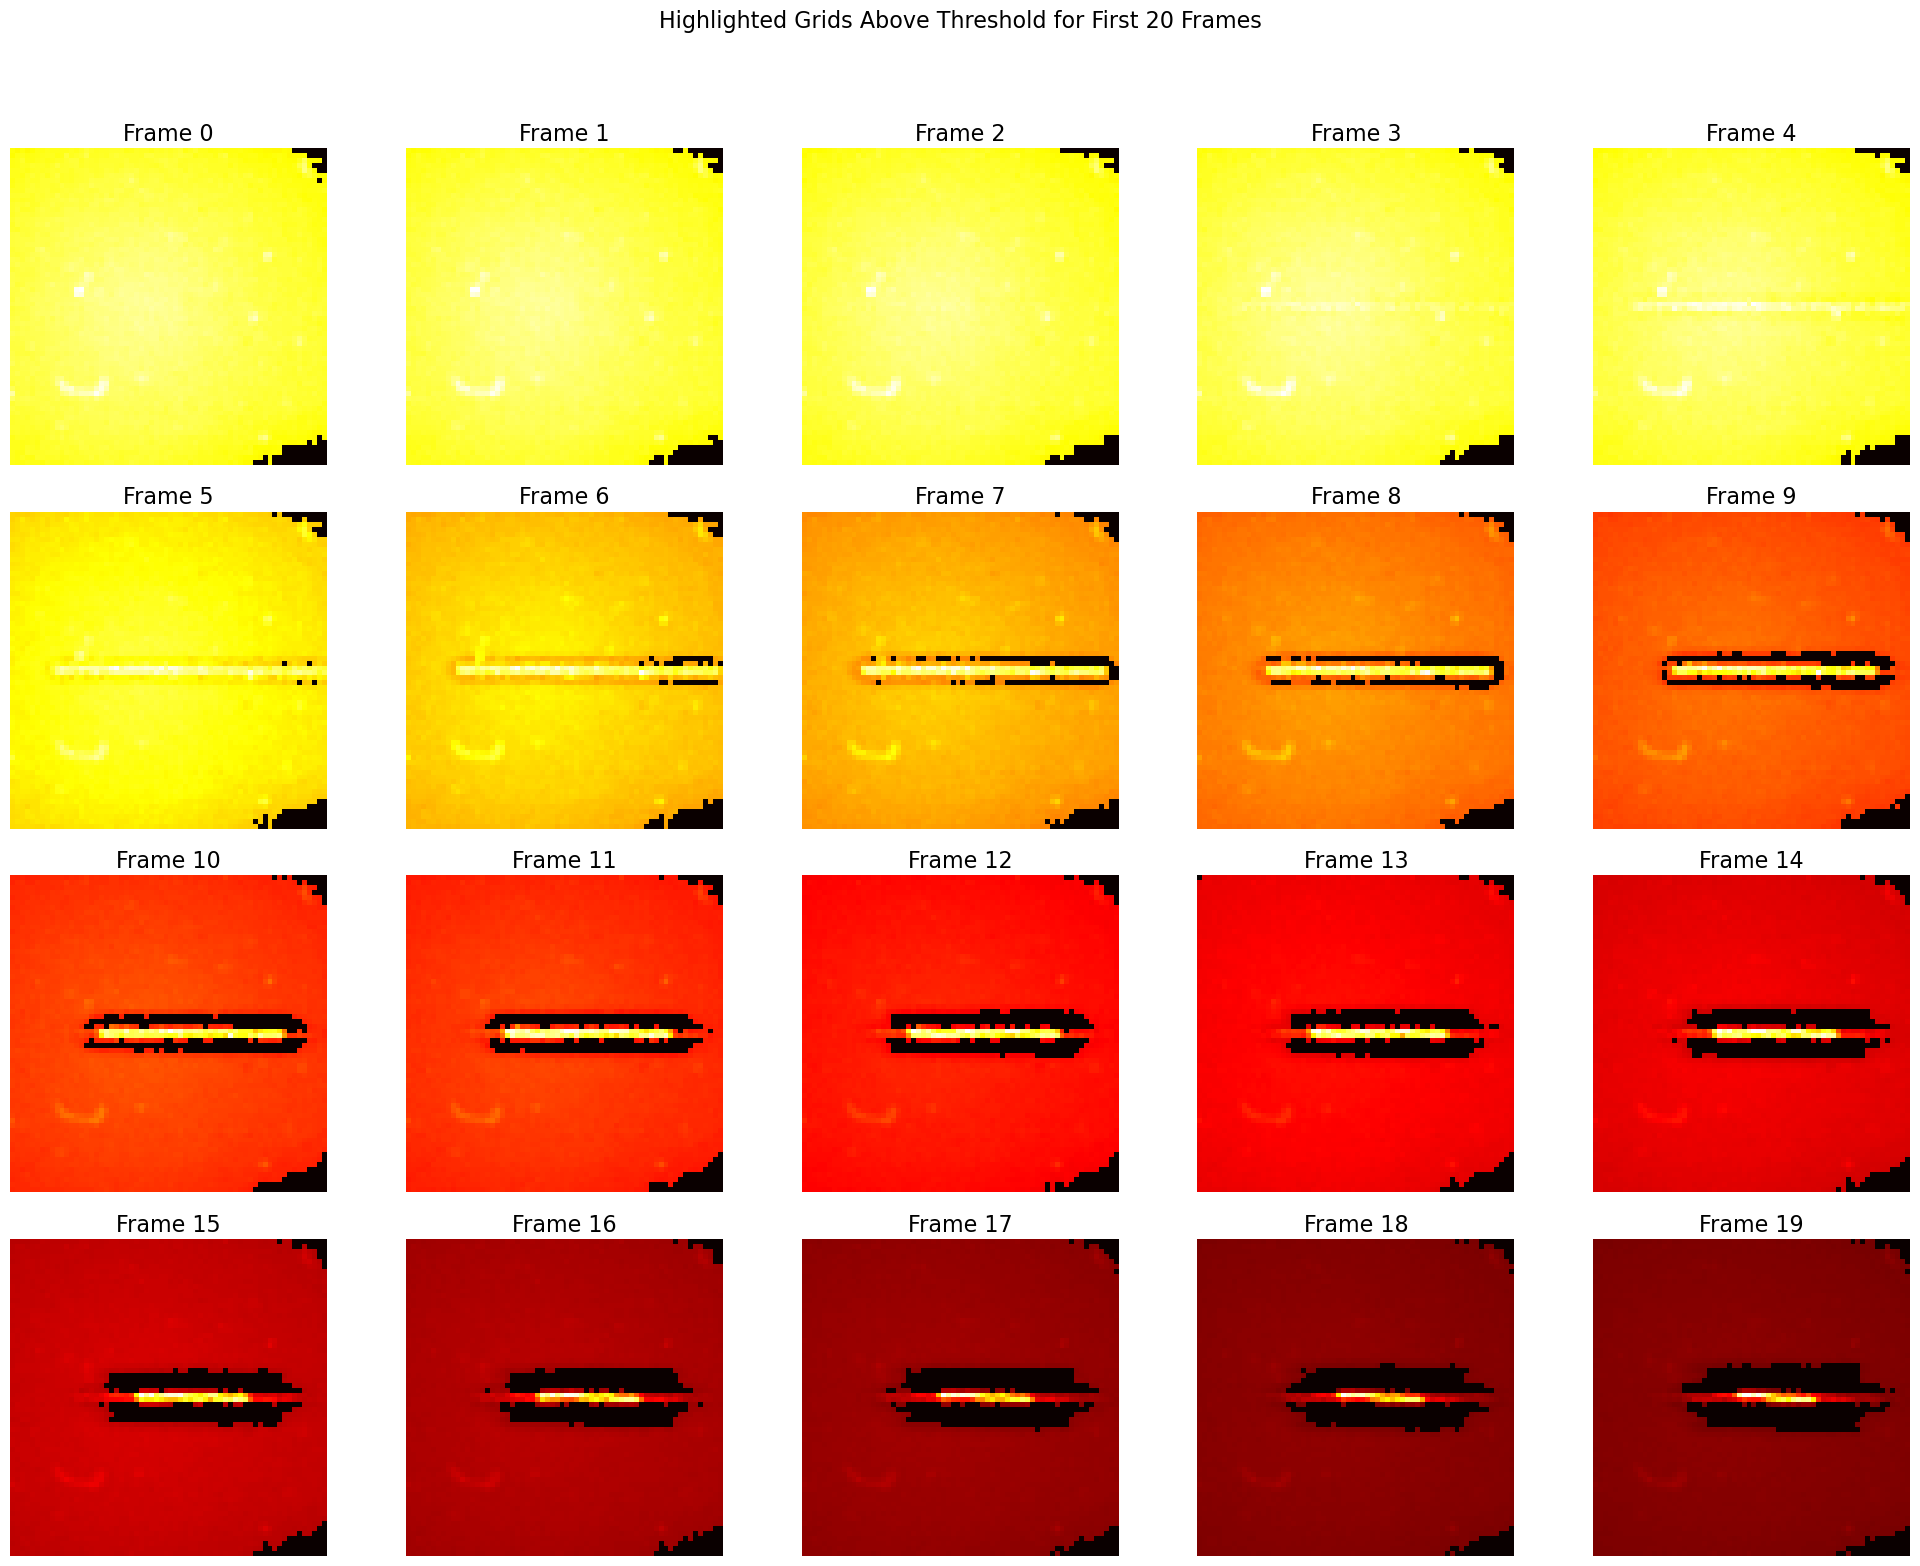

In [119]:
# Constants
PIXEL_SIZE_UM = 0.43  # Pixel size in micrometers
GRID_SIZE = (32, 32)  # Grid size
THRESHOLD_MT_DENSITY = 0.9  # Threshold for MT density in MT/um²

# Function to calculate microtubule density
def calculate_microtubule_density(image_np, calibration_factor):
    """Convert image intensity to microtubule number density."""
    return image_np * calibration_factor

# Function to process each image sequence and compute number of microtubules in each grid
def process_image_sequence(tiff_folder_path, grid_size=(32, 32)):
    tiff_files = sorted([f for f in os.listdir(tiff_folder_path) if 'Cy5_' in f and f.endswith('.tif')], key=natural_sort_key)
    results = []

    # Determine the calibration factor from the first frame
    first_image_path = os.path.join(tiff_folder_path, tiff_files[0])
    first_image = Image.open(first_image_path)
    first_image_np = np.array(first_image)
    first_image_np = uniform_filter(first_image_np, size=8)
    average_intensity_first_frame = np.mean(first_image_np)
    calibration_factor = 1 / average_intensity_first_frame  # Normalize to 1 MT/um^2

    for i, tiff_file in enumerate(tiff_files):
        image_path = os.path.join(tiff_folder_path, tiff_file)
        image = Image.open(image_path)
        image_np = np.array(image)
        
        # Apply uniform filter
        image_np = uniform_filter(image_np, size=8)
        
        height, width = image_np.shape
        cell_height, cell_width = grid_size
        mt_counts = []

        for y in range(0, height, cell_height):
            for x in range(0, width, cell_width):
                cell = image_np[y:y + cell_height, x:x + cell_width]
                mt_density = calculate_microtubule_density(cell, calibration_factor)
                mt_count = np.sum(mt_density) * (PIXEL_SIZE_UM ** 2)  # Convert density to count
                mt_counts.append(mt_count)

        results.append({
            'Frame': i,
            'MT_Counts': mt_counts
        })
    
    return results

# Function to calculate V_f based on threshold
def calculate_vf(mt_counts, threshold, pixel_size_um, grid_size):
    """Calculate the final volume V_f based on the threshold."""
    grid_cell_area_um2 = (grid_size[0] * pixel_size_um) * (grid_size[1] * pixel_size_um)
    V_f = 0

    for count in mt_counts:
        if count > threshold:
            V_f += grid_cell_area_um2

    return V_f

# Path to the specific folder to process
folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_120_min_no_6.1_1/Pos0'

# Process the image sequence
results = process_image_sequence(folder_path)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Calculate initial volume V_i as the full observed region
first_image = Image.open(os.path.join(folder_path, os.listdir(folder_path)[0]))
first_image_np = np.array(first_image)
height, width = first_image_np.shape
V_i = height * width * (PIXEL_SIZE_UM ** 2)
print(f"Initial volume V_i: {V_i:.2f} um^2")

# Calculate V_f for each frame
V_f_list = []
previous_V_f = V_i

for index, row in df.iterrows():
    mt_counts = row['MT_Counts']
    V_f = calculate_vf(mt_counts, THRESHOLD_MT_DENSITY * (GRID_SIZE[0] * PIXEL_SIZE_UM) * (GRID_SIZE[1] * PIXEL_SIZE_UM), PIXEL_SIZE_UM, GRID_SIZE)
    V_f_list.append(V_f)
    previous_V_f = V_f

df['V_f'] = V_f_list

# Calculate delta S for each frame using V_f of the previous frame as V_i
delta_S_list = [np.log(df['V_f'].iloc[i] / df['V_f'].iloc[i-1]) if i > 0 else np.log(df['V_f'].iloc[i] / V_i) for i in range(len(df))]

# Add delta S to the DataFrame
df['Delta_S'] = delta_S_list

# Plot Delta S over time (frame number)
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['Delta_S'], 'o-')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Change ΔS (kT)')
plt.title('Entropy Change ΔS over Time')
plt.grid(True)
plt.show()

# Function to highlight grids above the threshold
def highlight_grids(frame_data, grid_size=(32, 32), threshold=1):
    grid_height = int(len(frame_data) ** 0.5)  # Assuming a square grid
    grid_width = grid_height

    # Reshape the data into a 2D array for the heatmap
    frame_grid = np.array(frame_data).reshape(grid_height, grid_width)

    highlighted_grid = np.zeros_like(frame_grid)
    
    for grid_y in range(grid_height):
        for grid_x in range(grid_width):
            if frame_grid[grid_y, grid_x] > threshold:
                highlighted_grid[grid_y, grid_x] = frame_grid[grid_y, grid_x]
                        
    return highlighted_grid

# Plot highlighted grids for the first 20 frames, 5 plots per row
num_frames_to_plot = 20
frames_to_plot = df['Frame'].iloc[:num_frames_to_plot]
nrows = 4
ncols = 5

plt.figure(figsize=(20, 16))

for i, frame_number in enumerate(frames_to_plot):
    plt.subplot(nrows, ncols, i + 1)
    frame_data = df.loc[df['Frame'] == frame_number, 'MT_Counts'].values[0]
    highlighted_grid = highlight_grids(frame_data, GRID_SIZE, THRESHOLD_MT_DENSITY * (GRID_SIZE[0] * PIXEL_SIZE_UM) * (GRID_SIZE[1] * PIXEL_SIZE_UM))
    plt.imshow(highlighted_grid, cmap='hot', interpolation='nearest')
    plt.title(f'Frame {frame_number}')
    plt.axis('off')

plt.suptitle('Highlighted Grids Above Threshold for First 20 Frames', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [115]:
V_f

749587.5584000016

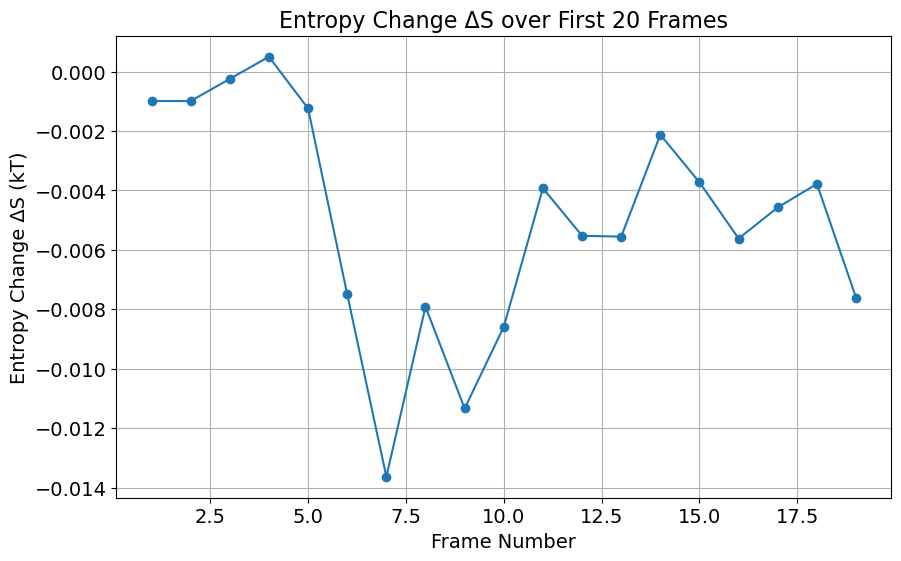

In [120]:
# Set default font sizes
plt.rcParams.update({'font.size': 14})  # Sets the default font size for all text
plt.rcParams.update({'axes.titlesize': 16})  # Sets the font size for titles
plt.rcParams.update({'axes.labelsize': 14})  # Sets the font size for labels

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'][1:20], df['Delta_S'][1:20], 'o-')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Change ΔS (kT)')
plt.title('Entropy Change ΔS over First 20 Frames')
plt.grid(True)
plt.show()


Initial volume V_i: 775526.81 um^2


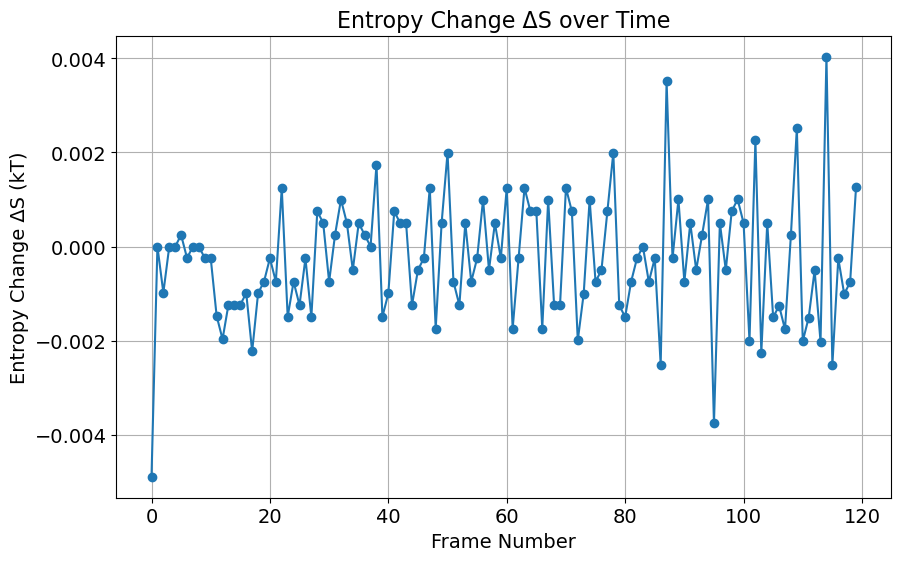

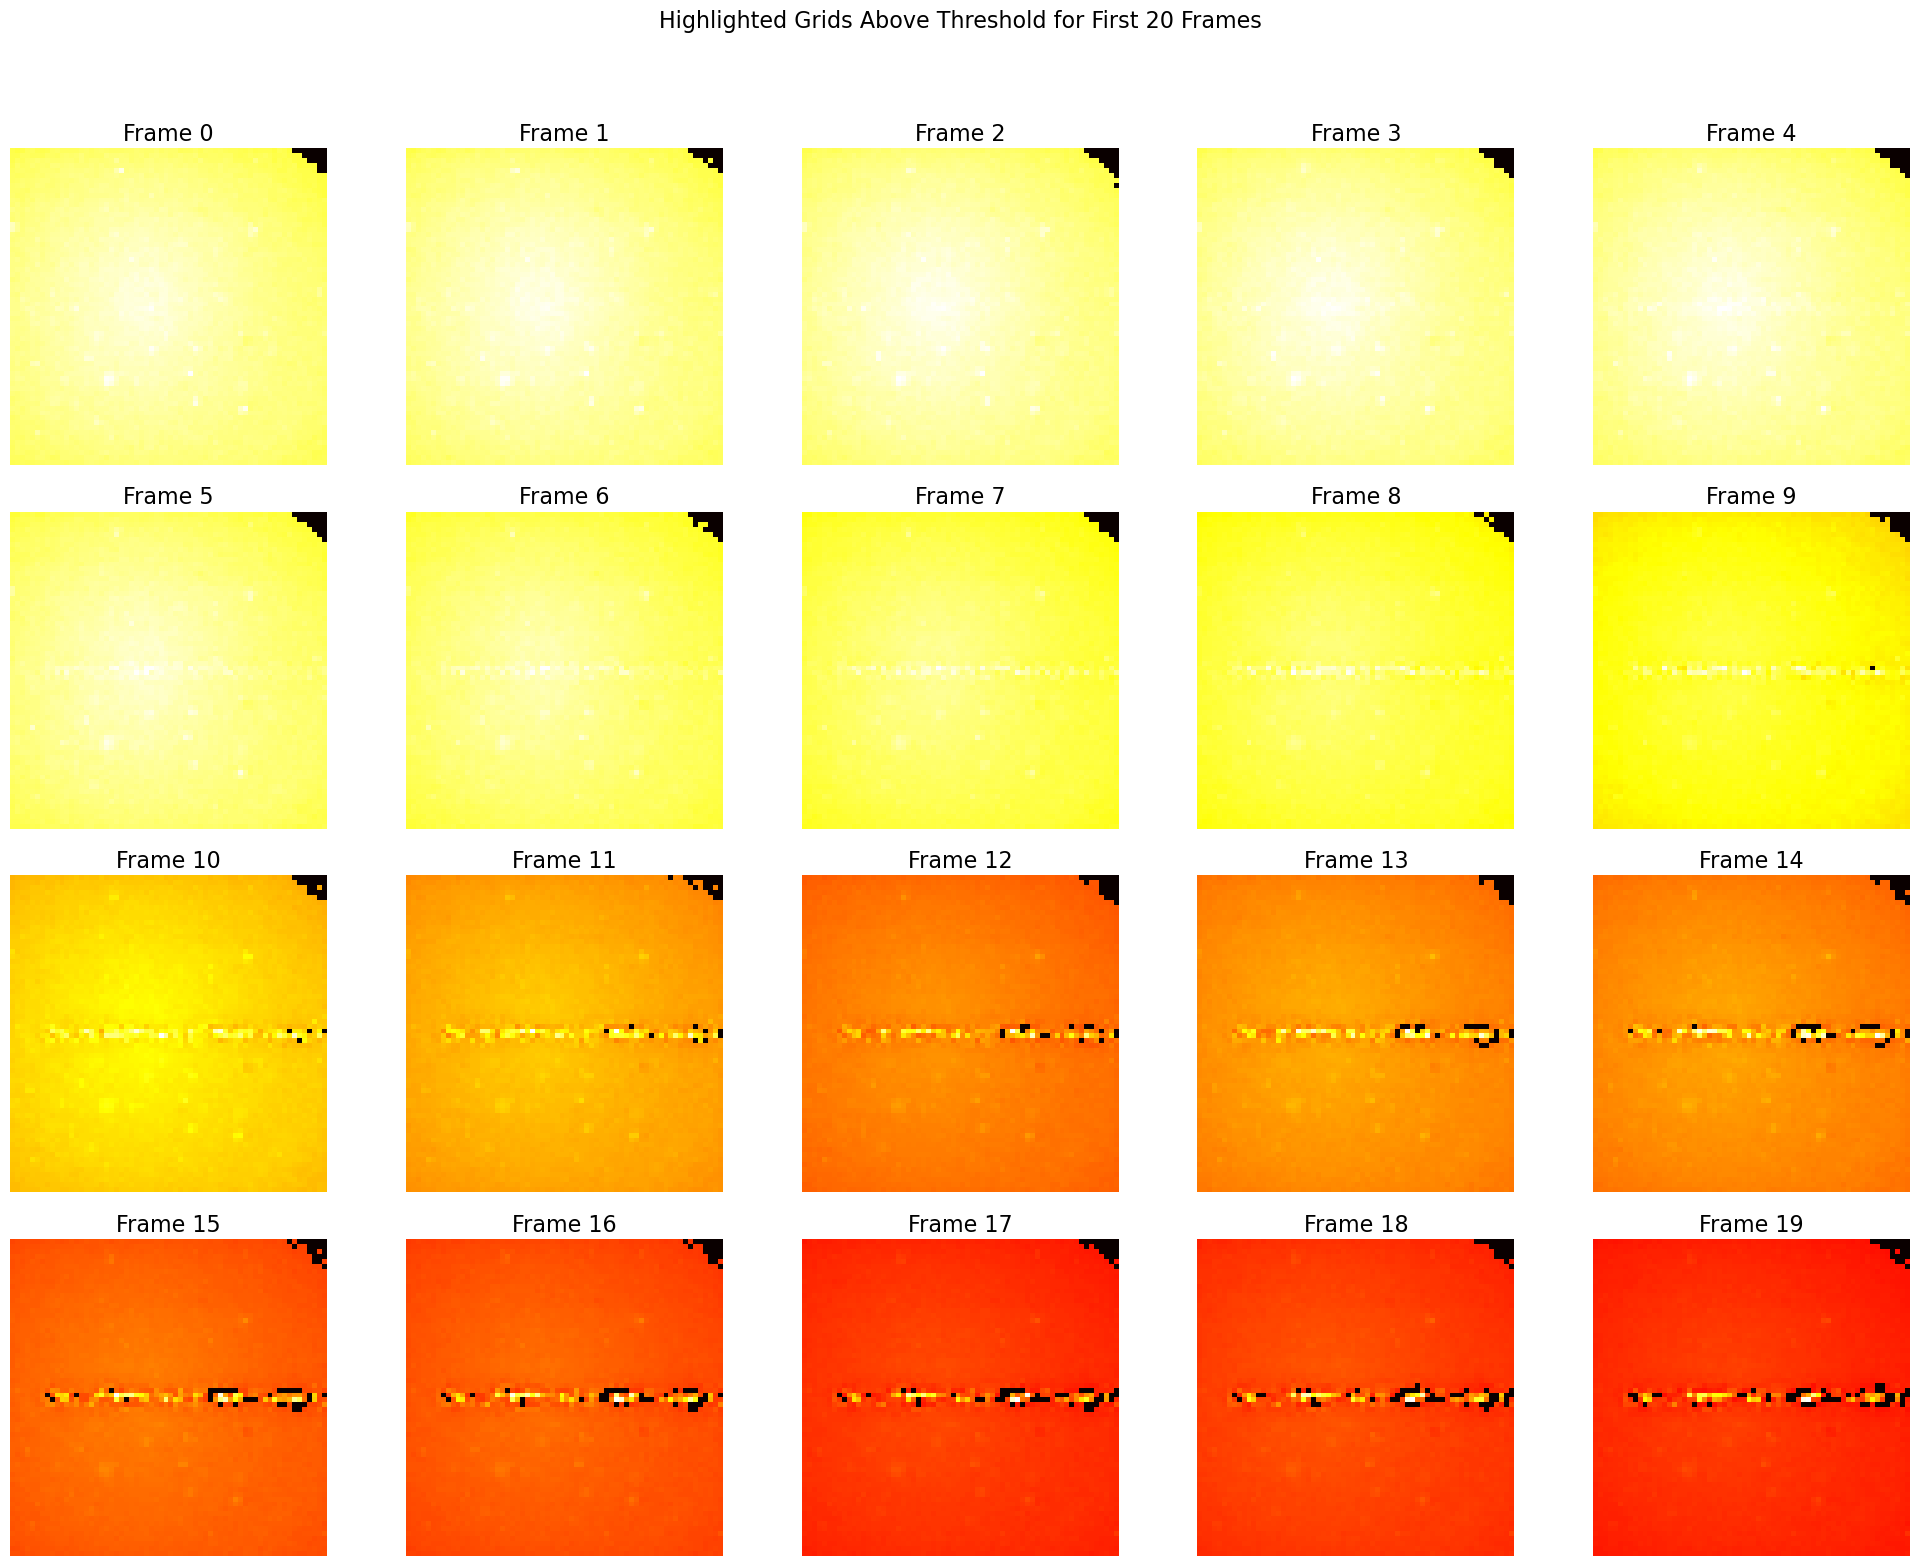

In [125]:


# Path to the specific folder to process
folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_10_min_no_6.1_1/Pos0'

# Process the image sequence
results = process_image_sequence(folder_path)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Calculate initial volume V_i as the full observed region
first_image = Image.open(os.path.join(folder_path, os.listdir(folder_path)[0]))
first_image_np = np.array(first_image)
height, width = first_image_np.shape
V_i = height * width * (PIXEL_SIZE_UM ** 2)
print(f"Initial volume V_i: {V_i:.2f} um^2")

# Calculate V_f for each frame
V_f_list = []
previous_V_f = V_i

for index, row in df.iterrows():
    mt_counts = row['MT_Counts']
    V_f = calculate_vf(mt_counts, THRESHOLD_MT_DENSITY * (GRID_SIZE[0] * PIXEL_SIZE_UM) * (GRID_SIZE[1] * PIXEL_SIZE_UM), PIXEL_SIZE_UM, GRID_SIZE)
    V_f_list.append(V_f)
    previous_V_f = V_f

df['V_f'] = V_f_list

# Calculate delta S for each frame using V_f of the previous frame as V_i
delta_S_list = [np.log(df['V_f'].iloc[i] / df['V_f'].iloc[i-1]) if i > 0 else np.log(df['V_f'].iloc[i] / V_i) for i in range(len(df))]

# Add delta S to the DataFrame
df['Delta_S'] = delta_S_list

# Plot Delta S over time (frame number)
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['Delta_S'], 'o-')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Change ΔS (kT)')
plt.title('Entropy Change ΔS over Time')
plt.grid(True)
plt.show()

# Function to highlight grids above the threshold
def highlight_grids(frame_data, grid_size=(32, 32), threshold=1):
    grid_height = int(len(frame_data) ** 0.5)  # Assuming a square grid
    grid_width = grid_height

    # Reshape the data into a 2D array for the heatmap
    frame_grid = np.array(frame_data).reshape(grid_height, grid_width)

    highlighted_grid = np.zeros_like(frame_grid)
    
    for grid_y in range(grid_height):
        for grid_x in range(grid_width):
            if frame_grid[grid_y, grid_x] > threshold:
                highlighted_grid[grid_y, grid_x] = frame_grid[grid_y, grid_x]
                        
    return highlighted_grid

# Plot highlighted grids for the first 20 frames, 5 plots per row
num_frames_to_plot = 20
frames_to_plot = df['Frame'].iloc[:num_frames_to_plot]
nrows = 4
ncols = 5

plt.figure(figsize=(20, 16))

for i, frame_number in enumerate(frames_to_plot):
    plt.subplot(nrows, ncols, i + 1)
    frame_data = df.loc[df['Frame'] == frame_number, 'MT_Counts'].values[0]
    highlighted_grid = highlight_grids(frame_data, GRID_SIZE, THRESHOLD_MT_DENSITY * (GRID_SIZE[0] * PIXEL_SIZE_UM) * (GRID_SIZE[1] * PIXEL_SIZE_UM))
    plt.imshow(highlighted_grid, cmap='hot', interpolation='nearest')
    plt.title(f'Frame {frame_number}')
    plt.axis('off')

plt.suptitle('Highlighted Grids Above Threshold for First 20 Frames', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


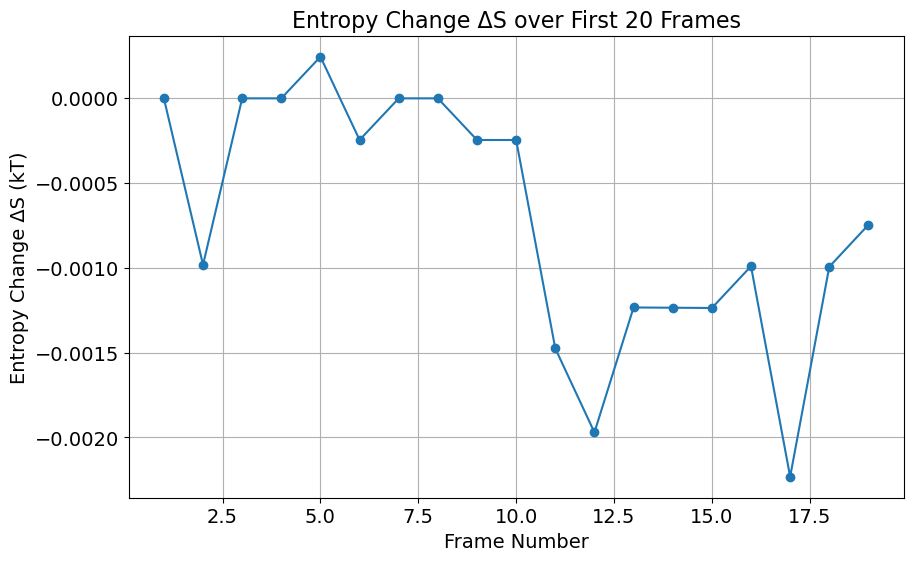

In [126]:
# Set default font sizes
plt.rcParams.update({'font.size': 14})  # Sets the default font size for all text
plt.rcParams.update({'axes.titlesize': 16})  # Sets the font size for titles
plt.rcParams.update({'axes.labelsize': 14})  # Sets the font size for labels

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'][1:20], df['Delta_S'][1:20], 'o-')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Change ΔS (kT)')
plt.title('Entropy Change ΔS over First 20 Frames')
plt.grid(True)
plt.show()


Initial volume V_i: 151470.08 um^2


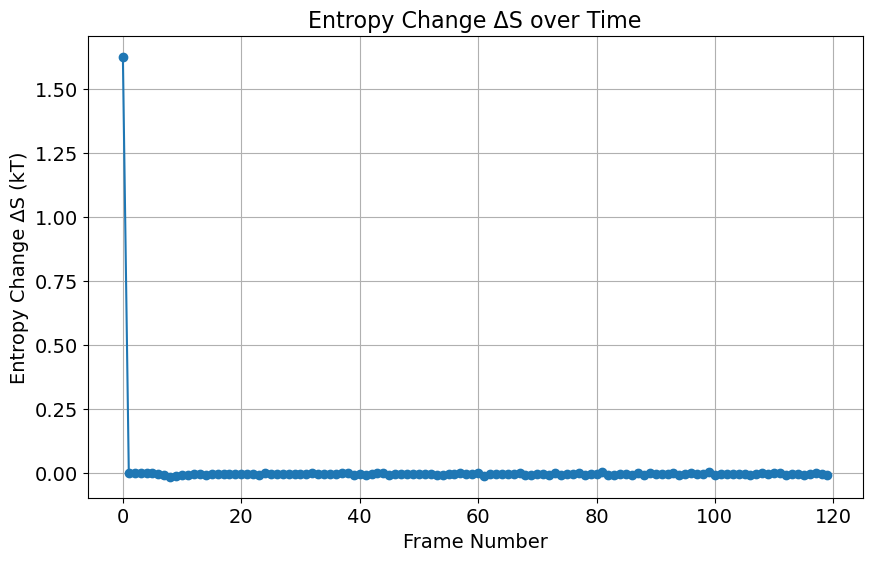

KeyError: 'Grid_Height'

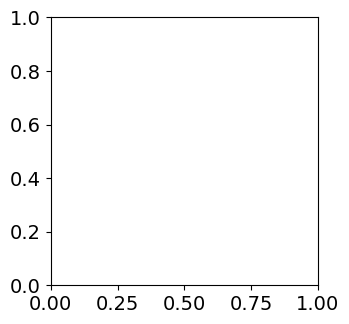

In [123]:


# Path to the specific folder to process
folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104/correlation_65_min_no_6.1_1/Pos0'

# Process the image sequence
results = process_image_sequence(folder_path, GRID_SIZE)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Calculate initial volume V_i as the full observed region
first_image = Image.open(os.path.join(folder_path, os.listdir(folder_path)[0]))
first_image_np = np.array(first_image)
height, width = first_image_np.shape
x_center = width // 2
x_start = max(x_center - 200, 0)
x_end = min(x_center + 200, width)
V_i = height * (x_end - x_start) * (PIXEL_SIZE_UM ** 2)
print(f"Initial volume V_i: {V_i:.2f} um^2")

# Calculate V_f for each frame
V_f_list = []
previous_V_f = V_i

for index, row in df.iterrows():
    mt_counts = row['MT_Counts']
    V_f = calculate_vf(mt_counts, THRESHOLD_MT_DENSITY * (GRID_SIZE[0] * PIXEL_SIZE_UM) * (GRID_SIZE[1] * PIXEL_SIZE_UM), PIXEL_SIZE_UM, GRID_SIZE)
    V_f_list.append(V_f)
    previous_V_f = V_f

df['V_f'] = V_f_list

# Calculate delta S for each frame using V_f of the previous frame as V_i
delta_S_list = [np.log(df['V_f'].iloc[i] / df['V_f'].iloc[i-1]) if i > 0 else np.log(df['V_f'].iloc[i] / V_i) for i in range(len(df))]

# Add delta S to the DataFrame
df['Delta_S'] = delta_S_list

# Plot Delta S over time (frame number)
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['Delta_S'], 'o-')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Change ΔS (kT)')
plt.title('Entropy Change ΔS over Time')
plt.grid(True)
plt.show()

# Plot highlighted grids for the first 20 frames, 5 plots per row
num_frames_to_plot = 20
frames_to_plot = df['Frame'].iloc[:num_frames_to_plot]
nrows = 4
ncols = 5
threshold = THRESHOLD_MT_DENSITY * (GRID_SIZE[0] * PIXEL_SIZE_UM) * (GRID_SIZE[1] * PIXEL_SIZE_UM)

plt.figure(figsize=(20, 16))

for i, frame_number in enumerate(frames_to_plot):
    plt.subplot(nrows, ncols, i + 1)
    frame_data = df.loc[df['Frame'] == frame_number, 'MT_Counts'].values[0]
    grid_height = df.loc[df['Frame'] == frame_number, 'Grid_Height'].values[0]
    grid_width = df.loc[df['Frame'] == frame_number, 'Grid_Width'].values[0]
    highlighted_grid = np.array(frame_data).reshape(grid_height, grid_width) > threshold
    plt.imshow(highlighted_grid, cmap='hot', interpolation='nearest')
    plt.title(f'Frame {frame_number}')
    plt.axis('off')

plt.suptitle('Highlighted Grids Above Threshold for First 20 Frames', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


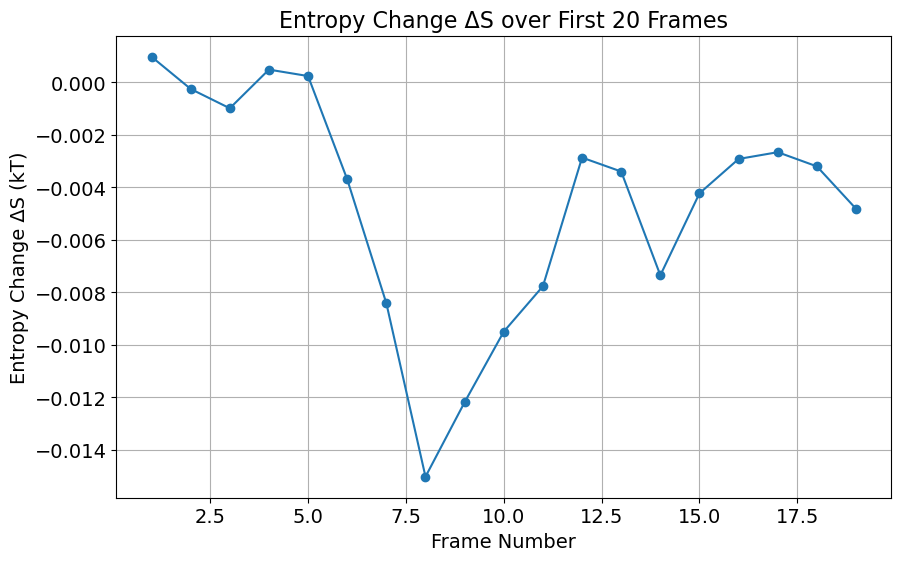

In [124]:
# Set default font sizes
plt.rcParams.update({'font.size': 14})  # Sets the default font size for all text
plt.rcParams.update({'axes.titlesize': 16})  # Sets the font size for titles
plt.rcParams.update({'axes.labelsize': 14})  # Sets the font size for labels

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'][1:20], df['Delta_S'][1:20], 'o-')
plt.xlabel('Frame Number')
plt.ylabel('Entropy Change ΔS (kT)')
plt.title('Entropy Change ΔS over First 20 Frames')
plt.grid(True)
plt.show()
